In [2]:
# ============================================================
# CELL 1 — IMPORTS & PLOTTING CONFIG
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 120


In [ ]:
# ============================================================
# CELL 2 — FILE PATHS (EDIT THESE!)
# ============================================================



FILES = {
    "positive": {
        "traces_A": r"\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\ContextA\cleaned_traces.csv",
        "traces_B": r"\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\ContextB\cleaned_traces.csv",

        "freeze_A": r"\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\freezing\363-crepos-ContextA.csv",
        "freeze_B": r"\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\freezing\363-crepos-ContextB.csv",

        # NOTE: Trailing space before ".csv" kept EXACTLY as provided
        "events_A": r"\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\Crepos-363_ContextA_events.csv",
        "events_B": r"\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\Crepos-363_ContextB_events.csv",
    },

    "negative": {
        "traces_A": r"\BME 534 - Advanced Machine Learning\Project\Creneg-746\Creneg-746\ContextA\cleaned_traces.csv",
        "traces_B": r"\BME 534 - Advanced Machine Learning\Project\Creneg-746\Creneg-746\ContextB\cleaned_traces.csv",

        "freeze_A": r"\BME 534 - Advanced Machine Learning\Project\Creneg-746\Creneg-746\freezing\746-creneg-ContextA.csv",
        
        
        "freeze_B": r"\BME 534 - Advanced Machine Learning\Project\Creneg-746\Creneg-746\freezing\746-creneg-ContextB.csv",

        # NOTE: Trailing space before ".csv" kept EXACTLY as provided
        "events_A": r"\BME 534 - Advanced Machine Learning\Project\Creneg-746\Creneg-746\Creneg-746_ContextA_events.csv",
        "events_B": r"\BME 534 - Advanced Machine Learning\Project\Creneg-746\Creneg-746\Creneg-746_ContextB_events.csv",
    }
}


In [4]:
# ============================================================
# CELL 3 — LOADING FUNCTIONS
# ============================================================

def load_group_data(group_name, file_dict):
    """Loads all CSV files for a given group (positive or negative)."""
    group_data = {}

    for key, filepath in file_dict.items():
        print(f"Loading {group_name} → {key}: {filepath}")
        try:
            df = pd.read_csv(filepath)
            group_data[key] = df
            print(f"  ✔ Loaded shape: {df.shape}")
        except Exception as e:
            print(f"  ✘ Error loading {filepath}: {e}")
            group_data[key] = None

    return group_data


positive_data = load_group_data("positive", FILES["positive"])
negative_data = load_group_data("negative", FILES["negative"])


def summarize_group(name, data):
    print("\n==============================")
    print(f" Summary for group: {name}")
    print("==============================")
    for key, df in data.items():
        if df is not None:
            print(f"{key:15s} → rows: {len(df):5d}, cols: {len(df.columns):3d}")
        else:
            print(f"{key:15s} → NOT LOADED")


print("\n\n### SUMMARY OF LOADED DATA ###")
summarize_group("Positive", positive_data)
summarize_group("Negative", negative_data)


Loading positive → traces_A: C:\Users\sina7\Dropbox\Courses\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\ContextA\cleaned_traces.csv
  ✔ Loaded shape: (3001, 784)
Loading positive → traces_B: C:\Users\sina7\Dropbox\Courses\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\ContextB\cleaned_traces.csv
  ✔ Loaded shape: (3001, 784)
Loading positive → freeze_A: C:\Users\sina7\Dropbox\Courses\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\freezing\363-crepos-ContextA.csv
  ✔ Loaded shape: (2401, 3)
Loading positive → freeze_B: C:\Users\sina7\Dropbox\Courses\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\freezing\363-crepos-ContextB.csv
  ✔ Loaded shape: (2401, 3)
Loading positive → events_A: C:\Users\sina7\Dropbox\Courses\BME 534 - Advanced Machine Learning\Project\Crepos-363\Crepos-363\Crepos-363_ContextA_events.csv
  ✔ Loaded shape: (28423, 3)
Loading positive → events_B: C:\Users\sina7\Dropbox\Courses\BME 534 - Ad

In [64]:
# ============================================================
# CELL — PROCESSING PARAMS & FUNCTIONS (with Winsorization)
# ============================================================

DOWNSAMPLE_INTERVAL_SEC = 1   # 1 second bins
APPLY_OUTLIER_REMOVAL = True    # <-- set False to disable Winsorization
OUTLIER_LOW_PCT = 1.0           # lower percentile for clipping
OUTLIER_HIGH_PCT = 99.0         # upper percentile for clipping

print(f"Downsample interval: {DOWNSAMPLE_INTERVAL_SEC} sec")
print(f"Outlier (winsorization) enabled: {APPLY_OUTLIER_REMOVAL}")
print(f"Winsorization percentiles: [{OUTLIER_LOW_PCT}, {OUTLIER_HIGH_PCT}]")


def downsample_traces(df, interval_sec):
    """
    Downsample trace dataframe by taking the mean over each interval.
    Assumes:
        - First column is time in seconds.
        - Remaining columns are neuron traces.

    Returns:
        DataFrame with index = time bin (sec), columns = neurons.
    """
    df = df.copy()
    time_col = df.columns[0]

    # Integer time bins (0,1,2,... for 1s bins)
    df["time_bin"] = (df[time_col] // interval_sec).astype(int)

    # Group by time_bin and average
    df_ds = df.groupby("time_bin").mean()

    # Drop original time column if still present
    df_ds = df_ds.drop(columns=[time_col], errors="ignore")

    # Use time_bin as index in seconds
    df_ds.index = df_ds.index.astype(float) * interval_sec
    df_ds.index.name = "Time (s)"

    return df_ds


def remove_outliers_per_neuron(df, low_pct=OUTLIER_LOW_PCT, high_pct=OUTLIER_HIGH_PCT):
    """
    Percentile Winsorization per neuron (column):
      - Values below `low_pct` percentile are set to that percentile.
      - Values above `high_pct` percentile are set to that percentile.

    This is *not* removing real events, just clipping extreme tails.
    """
    df_clip = df.copy()

    for col in df_clip.columns:
        x = df_clip[col].values

        # Compute percentiles for this neuron
        lo = np.nanpercentile(x, low_pct)
        hi = np.nanpercentile(x, high_pct)

        # Clip values into [lo, hi]
        x_clipped = np.clip(x, lo, hi)
        df_clip[col] = x_clipped

    return df_clip


def min_max_normalize_per_neuron(df):
    """
    Per-neuron (per-column) Min–Max normalization to [0, 1].
    """
    df_norm = df.copy()

    for col in df_norm.columns:
        col_min = df_norm[col].min()
        col_max = df_norm[col].max()

        if col_max == col_min:
            df_norm[col] = 0.0
        else:
            df_norm[col] = (df_norm[col] - col_min) / (col_max - col_min)

    # Safety: remove any NaNs that might appear
    df_norm = df_norm.fillna(0.0)
    return df_norm


def process_trace_file(df, interval_sec):
    """
    Full pipeline for one trace file:
      1) Downsample to interval_sec using mean
      2) (Optional) Per-neuron Winsorization (percentile clipping)
      3) Per-neuron 0–1 Min–Max normalization
    """
    # 1) Downsample
    ds = downsample_traces(df, interval_sec)

    # 2) Optional winsorization (percentile clipping)
    if APPLY_OUTLIER_REMOVAL:
        ds_clean = remove_outliers_per_neuron(ds,
                                              low_pct=OUTLIER_LOW_PCT,
                                              high_pct=OUTLIER_HIGH_PCT)
    else:
        ds_clean = ds

    # 3) Per-neuron min–max normalization
    norm = min_max_normalize_per_neuron(ds_clean)
    return norm


Downsample interval: 1 sec
Outlier (winsorization) enabled: True
Winsorization percentiles: [1.0, 99.0]


In [65]:
# ============================================================
# CELL 5 — APPLY PROCESSING TO ALL TRACE FILES
# ============================================================

def process_group_traces(group_data, interval_sec):
    processed = {}
    for key, df in group_data.items():
        if key.startswith("traces") and df is not None:
            print(f"Processing {key} ...")
            processed_df = process_trace_file(df, interval_sec)
            processed[key] = processed_df
            print(f"  ✔ Processed shape: {processed_df.shape}")
    return processed


positive_processed_traces = process_group_traces(positive_data, DOWNSAMPLE_INTERVAL_SEC)
negative_processed_traces = process_group_traces(negative_data, DOWNSAMPLE_INTERVAL_SEC)

print("\nProcessing complete!")


Processing traces_A ...
  ✔ Processed shape: (300, 783)
Processing traces_B ...
  ✔ Processed shape: (300, 783)
Processing traces_A ...
  ✔ Processed shape: (300, 171)
Processing traces_B ...
  ✔ Processed shape: (300, 171)

Processing complete!


In [66]:
# ============================================================
# CELL 6 — SANITY CHECK: NORMALIZATION & BASIC STATS
# ============================================================

# Example: check Positive – traces_A
df = positive_processed_traces["traces_A"]

print("Shape:", df.shape)
print("Global min:", df.values.min())
print("Global max:", df.values.max())
print("Any NaNs?", np.isnan(df.values).any())

per_neuron_min = df.min()
per_neuron_max = df.max()
per_neuron_std = df.std()

print("\nExample of per-neuron stats:")
display(pd.DataFrame({
    "min": per_neuron_min.head(),
    "max": per_neuron_max.head(),
    "std": per_neuron_std.head(),
}))


Shape: (300, 783)
Global min: 0.0
Global max: 1.0
Any NaNs? False

Example of per-neuron stats:


min  max       std
C0001  0.0  1.0  0.156902
C0004  0.0  1.0  0.131610
C0005  0.0  1.0  0.164578
C0006  0.0  1.0  0.187882
C0007  0.0  1.0  0.162287

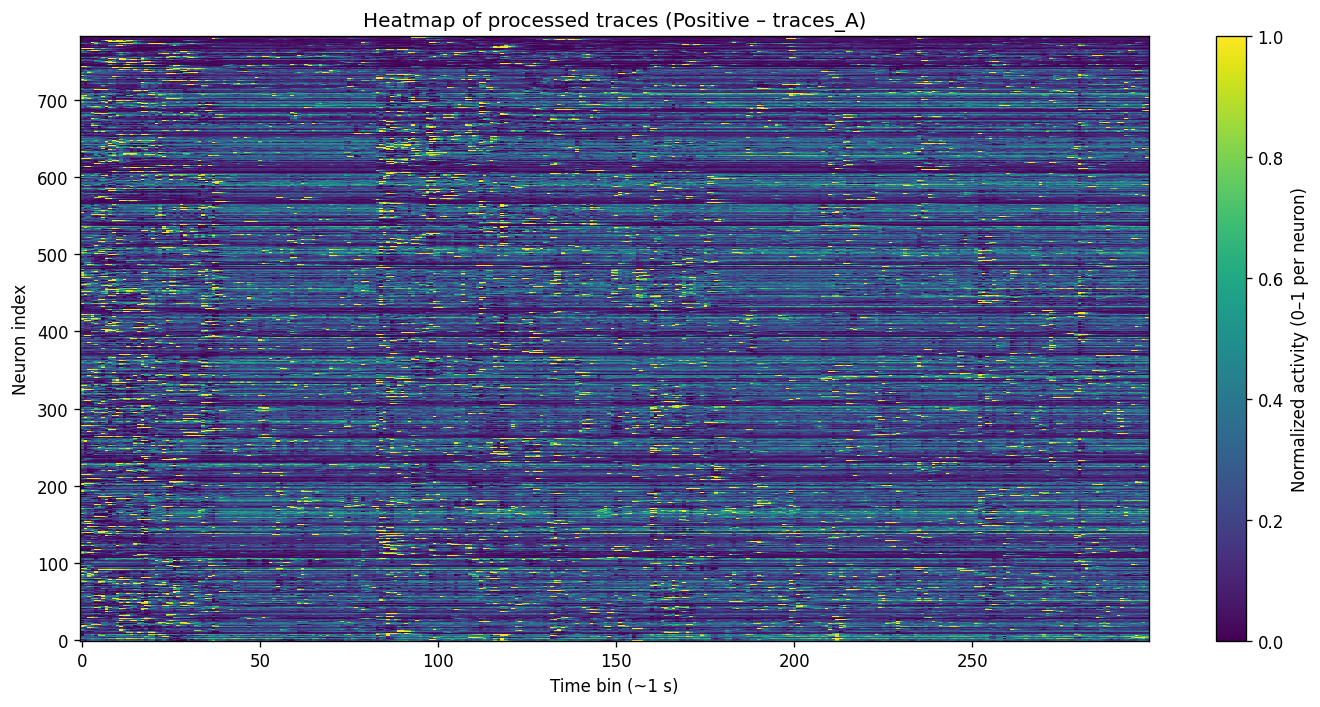

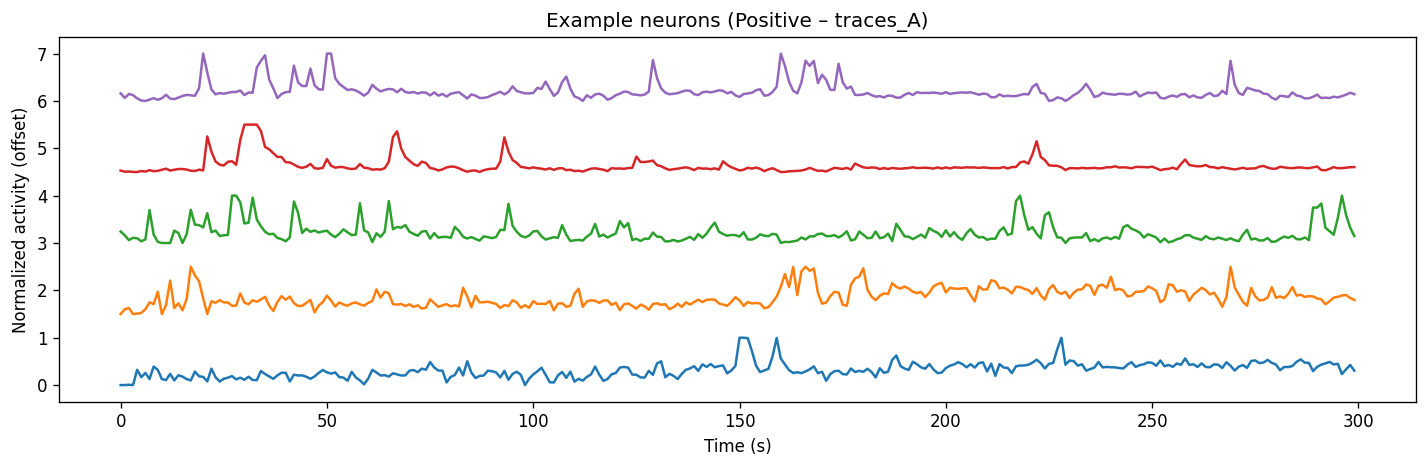

In [67]:
# ============================================================
# CELL 7 — VISUALIZATION: HEATMAP + SAMPLE NEURONS
# ============================================================

# Heatmap of all neurons
plt.figure(figsize=(12, 6))
plt.imshow(df.T, aspect='auto', origin='lower', interpolation='nearest')
plt.colorbar(label="Normalized activity (0–1 per neuron)")
plt.xlabel("Time bin (~1 s)")
plt.ylabel("Neuron index")
plt.title("Heatmap of processed traces (Positive – traces_A)")
plt.tight_layout()
plt.show()

# Plot a few random neurons with vertical offsets
plt.figure(figsize=(12, 4))
n_to_plot = 5
rand_indices = np.random.choice(df.shape[1], size=min(n_to_plot, df.shape[1]), replace=False)

for i, idx in enumerate(rand_indices):
    plt.plot(df.index, df.iloc[:, idx] + i * 1.5, label=f"Neuron {idx}")

plt.xlabel("Time (s)")
plt.ylabel("Normalized activity (offset)")
plt.title("Example neurons (Positive – traces_A)")
plt.tight_layout()
plt.show()


In [68]:
# ============================================================
# CELL 8 — NMF HELPERS (UPDATED)
# ============================================================

from sklearn.decomposition import NMF

def circular_shuffle_activity(A, rng=None):
    """
    Circularly shuffle each neuron's time series independently.
    A: (T x N) activity matrix.
    """
    if rng is None:
        rng = np.random.RandomState()
    T, N = A.shape
    A_shuf = np.empty_like(A)
    for j in range(N):
        shift = rng.randint(0, T)
        A_shuf[:, j] = np.roll(A[:, j], shift)
    return A_shuf


def fit_nmf(A, n_components, random_state=None, max_iter=4000):
    """
    Fit NMF to activity matrix A (time x neurons).
    Returns W, H, err, model:
      W: time x k
      H: k x neurons
      err: Frobenius norm of reconstruction error
    """
    model = NMF(
        n_components=n_components,
        init="nndsvda",
        solver="cd",
        beta_loss="frobenius",
        max_iter=max_iter,
        random_state=random_state,
        alpha_W=0.0,
        alpha_H=0.0,
        l1_ratio=0.0,
        tol=1e-4,
    )
    W = model.fit_transform(A)
    H = model.components_
    recon = W @ H
    err = np.linalg.norm(A - recon, ord="fro")
    return W, H, err, model


def choose_n_ensembles_by_recon_error(
    A,
    k_min=8,          # <-- start at 8
    k_max=20,         # <-- up to 20
    n_shuffles=5,
    random_state=0,
):
    """
    For k = k_min..k_max:
      - Fit NMF on real data and compute reconstruction error.
      - Fit NMF on n_shuffles circularly-shuffled matrices and average reconstruction error.
    Then compute the discrete derivative (error drop):
      Δreal(k)  = err_real(k-1)  - err_real(k)
      Δshuff(k) = err_shuff(k-1) - err_shuff(k)
    and choose k where (Δreal - Δshuff) is maximal.
    """
    rng = np.random.RandomState(random_state)
    ks = np.arange(k_min, k_max + 1)
    real_err = []
    shuff_err_mean = []

    print("Choosing number of ensembles (k) ...")

    for k in ks:
        print(f"  k = {k}")
        # Real data
        _, _, err_real_k, _ = fit_nmf(A, k, random_state=rng.randint(1e9))
        real_err.append(err_real_k)

        # Shuffled (chance) data
        shuff_errs = []
        for s in range(n_shuffles):
            Ash = circular_shuffle_activity(A, rng=rng)
            _, _, e_s, _ = fit_nmf(Ash, k, random_state=rng.randint(1e9))
            shuff_errs.append(e_s)
        shuff_err_mean.append(np.mean(shuff_errs))

    real_err = np.array(real_err)
    shuff_err_mean = np.array(shuff_err_mean)

    # Error drops when increasing k
    delta_real = real_err[:-1] - real_err[1:]
    delta_shuff = shuff_err_mean[:-1] - shuff_err_mean[1:]
    ks_for_delta = ks[1:]

    advantage = delta_real - delta_shuff
    best_idx = np.argmax(advantage)
    best_k = int(ks_for_delta[best_idx])

    print("\nReconstruction error (real):   ", real_err)
    print("Reconstruction error (shuffle):", shuff_err_mean)
    print("Δreal:   ", delta_real)
    print("Δshuff:  ", delta_shuff)
    print("Advantage (Δreal - Δshuff):", advantage)
    print(f"\nChosen number of ensembles k = {best_k} (max advantage)")

    # Plots
    plt.figure(figsize=(6,4))
    plt.plot(ks, real_err, "-o", label="Real")
    plt.plot(ks, shuff_err_mean, "-o", label="Shuffled (mean)")
    plt.xlabel("Number of ensembles (k)")
    plt.ylabel("Reconstruction error")
    plt.title("NMF reconstruction error vs number of ensembles")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(ks_for_delta, advantage, "-o")
    plt.axhline(0, linestyle="--")
    plt.xlabel("Number of ensembles (k)")
    plt.ylabel("Advantage: Δreal - Δshuff")
    plt.title("Error-drop advantage over shuffled")
    plt.tight_layout()
    plt.show()

    return best_k, ks, real_err, shuff_err_mean


def extract_ensembles_from_H(H, neuron_labels=None, top_n=None):
    """
    Extract neuron ensembles from NMF H matrix (k x neurons).
    Returns:
      ensemble_id -> dict with indices, weights, labels.
    If top_n is not None, keep only the top_n neurons per ensemble.
    """
    k, n_neurons = H.shape
    if neuron_labels is None:
        neuron_labels = np.arange(n_neurons)

    ensembles = {}
    for i in range(k):
        weights = H[i, :]
        sorted_idx = np.argsort(weights)[::-1]  # descending
        if top_n is not None:
            sorted_idx = sorted_idx[:top_n]
        ensembles[i] = {
            "indices": sorted_idx,
            "weights": weights[sorted_idx],
            "labels": neuron_labels[sorted_idx],
        }
    return ensembles


k=8, recon error=67.6677
k=9, recon error=66.6985
k=10, recon error=65.7981
k=11, recon error=64.9091
k=12, recon error=64.1537
k=13, recon error=63.4557
k=14, recon error=62.7218
k=15, recon error=62.0361
k=16, recon error=61.3940
k=17, recon error=60.7287
k=18, recon error=60.2158
k=19, recon error=59.5341
k=20, recon error=59.0476


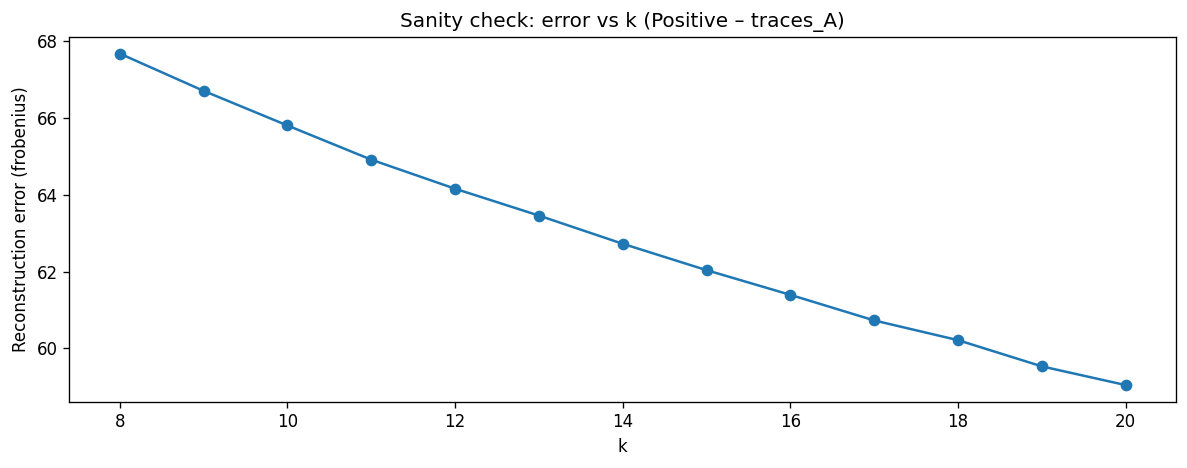

In [69]:
# ============================================================
# CELL 9 — QUICK NMF SANITY CHECK ON ONE FILE (UPDATED RANGE)
# ============================================================

A_test = positive_processed_traces["traces_A"].values

errs = []
ks = range(8, 21)   # k = 8..20

for k in ks:
    _, _, e, _ = fit_nmf(A_test, k, random_state=0)
    errs.append(e)
    print(f"k={k}, recon error={e:.4f}")

plt.figure()
plt.plot(list(ks), errs, "-o")
plt.xlabel("k")
plt.ylabel("Reconstruction error (frobenius)")
plt.title("Sanity check: error vs k (Positive – traces_A)")
plt.tight_layout()
plt.show()



 NMF for group: positive

--- positive – traces_A ---
Choosing number of ensembles (k) ...
  k = 8
  k = 9
  k = 10
  k = 11
  k = 12
  k = 13
  k = 14
  k = 15
  k = 16
  k = 17
  k = 18
  k = 19
  k = 20

Reconstruction error (real):    [67.6677251  66.69849615 65.79806667 64.90911108 64.15365607 63.45564586
 62.71931004 62.03608551 61.39428068 60.8097419  60.14951473 59.52276785
 58.92778795]
Reconstruction error (shuffle): [70.87245628 70.10259693 69.36309412 68.6839321  67.97265093 67.3409313
 66.6769956  66.02125237 65.37546996 64.74671268 64.18447649 63.57476926
 63.00674865]
Δreal:    [0.96922895 0.90042948 0.88895559 0.75545501 0.69801021 0.73633582
 0.68322453 0.64180483 0.58453878 0.66022718 0.62674687 0.5949799 ]
Δshuff:   [0.76985934 0.73950281 0.67916202 0.71128117 0.63171963 0.6639357
 0.65574323 0.64578242 0.62875728 0.56223618 0.60970724 0.5680206 ]
Advantage (Δreal - Δshuff): [ 0.1993696   0.16092667  0.20979357  0.04417383  0.06629059  0.07240012
  0.0274813  -0.003

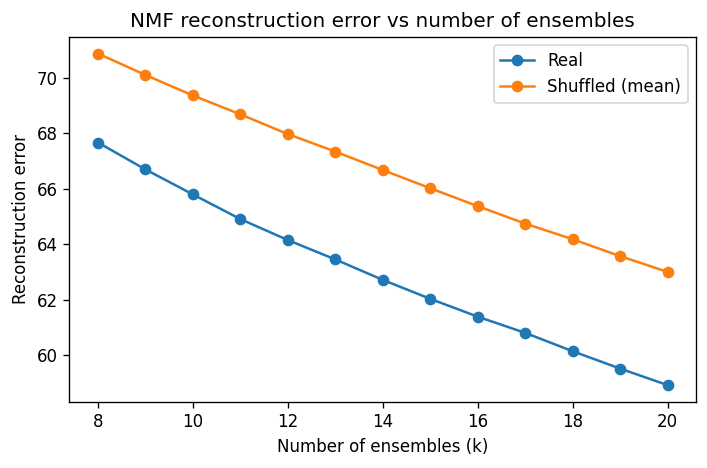

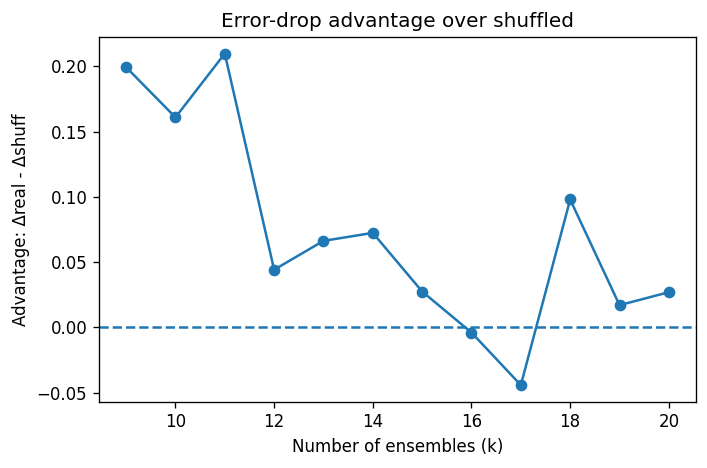

  → best_k = 11, A.shape = (300, 783)

--- positive – traces_B ---
Choosing number of ensembles (k) ...
  k = 8
  k = 9
  k = 10
  k = 11
  k = 12
  k = 13
  k = 14
  k = 15
  k = 16
  k = 17
  k = 18
  k = 19
  k = 20

Reconstruction error (real):    [66.68719315 65.71482038 64.7577557  63.90398069 63.14296531 62.42900031
 61.71081103 61.04475236 60.41937307 59.83123621 59.1227999  58.53142646
 57.94132226]
Reconstruction error (shuffle): [70.16333632 69.45447913 68.81625689 68.13190151 67.5099929  66.87931166
 66.30501577 65.69698785 65.05161024 64.49758366 63.95614623 63.36903562
 62.75377558]
Δreal:    [0.97237277 0.95706468 0.85377501 0.76101538 0.71396501 0.71818928
 0.66605867 0.62537929 0.58813686 0.70843632 0.59137344 0.5901042 ]
Δshuff:   [0.70885719 0.63822224 0.68435538 0.62190861 0.63068124 0.57429589
 0.60802792 0.64537761 0.55402658 0.54143743 0.58711061 0.61526004]
Advantage (Δreal - Δshuff): [ 0.26351558  0.31884244  0.16941963  0.13910677  0.08328376  0.14389338
  0.0

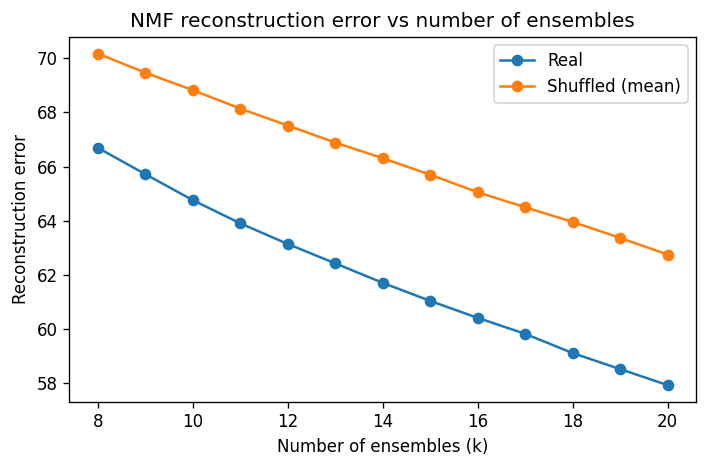

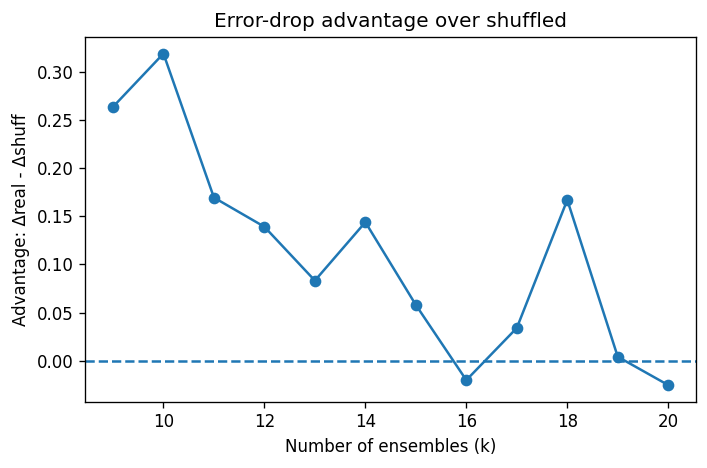

  → best_k = 10, A.shape = (300, 783)

 NMF for group: negative

--- negative – traces_A ---
Choosing number of ensembles (k) ...
  k = 8
  k = 9
  k = 10
  k = 11
  k = 12
  k = 13
  k = 14
  k = 15
  k = 16
  k = 17
  k = 18
  k = 19
  k = 20

Reconstruction error (real):    [30.82967326 30.35343682 29.87242294 29.44294454 29.1458112  28.69011173
 28.36255126 27.98304781 27.65333605 27.35804002 27.02867004 26.684743
 26.41454158]
Reconstruction error (shuffle): [32.49144978 32.13024703 31.71965167 31.36981512 31.01757646 30.6819138
 30.29481899 30.02202116 29.62127953 29.36166088 29.07042432 28.81012105
 28.43452744]
Δreal:    [0.47623644 0.48101388 0.4294784  0.29713335 0.45569946 0.32756048
 0.37950345 0.32971176 0.29529602 0.32936998 0.34392705 0.27020142]
Δshuff:   [0.36120275 0.41059536 0.34983655 0.35223866 0.33566266 0.38709481
 0.27279783 0.40074163 0.25961865 0.29123656 0.26030327 0.37559361]
Advantage (Δreal - Δshuff): [ 0.11503369  0.07041852  0.07964185 -0.05510531  0.120

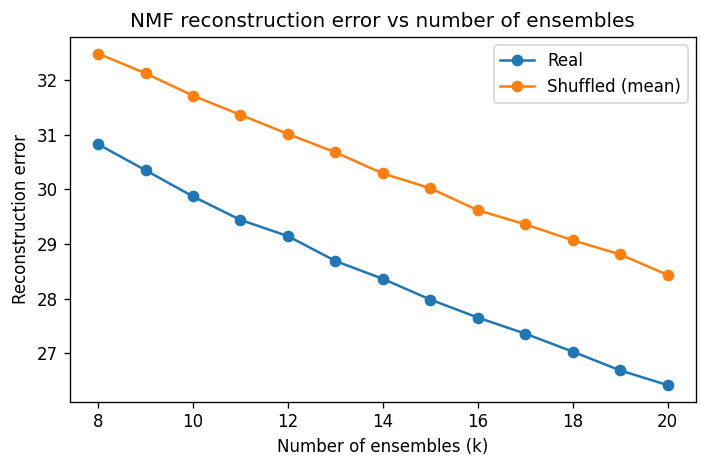

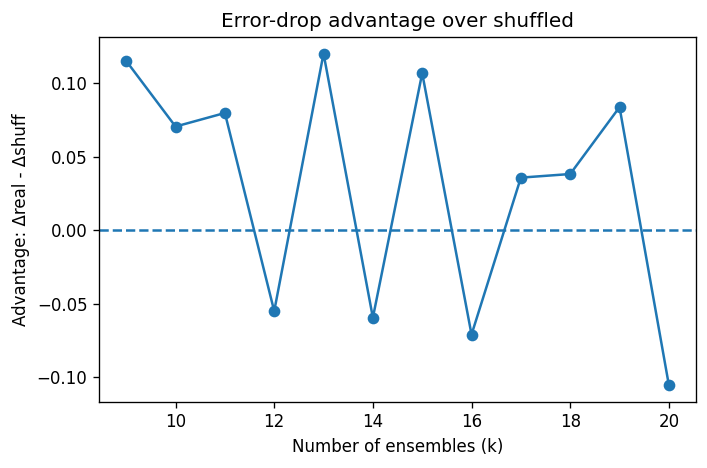

  → best_k = 13, A.shape = (300, 171)

--- negative – traces_B ---
Choosing number of ensembles (k) ...
  k = 8
  k = 9
  k = 10
  k = 11
  k = 12
  k = 13
  k = 14
  k = 15
  k = 16
  k = 17
  k = 18
  k = 19
  k = 20

Reconstruction error (real):    [30.56408984 30.06839158 29.64300127 29.20129593 28.79909621 28.42287215
 28.05451747 27.69511194 27.32738403 27.01198702 26.65382676 26.33379752
 26.01007245]
Reconstruction error (shuffle): [31.91632604 31.46049532 31.13949932 30.73405035 30.46817609 30.00771752
 29.65168107 29.34403095 29.00574628 28.68456624 28.40751712 28.14219099
 27.79949616]
Δreal:    [0.49569826 0.4253903  0.44170534 0.40219972 0.37622406 0.36835468
 0.35940553 0.36772791 0.31539701 0.35816027 0.32002923 0.32372507]
Δshuff:   [0.45583072 0.32099599 0.40544897 0.26587426 0.46045857 0.35603645
 0.30765012 0.33828467 0.32118004 0.27704912 0.26532613 0.34269483]
Advantage (Δreal - Δshuff): [ 0.03986754  0.10439431  0.03625637  0.13632546 -0.08423451  0.01231823
  0.0

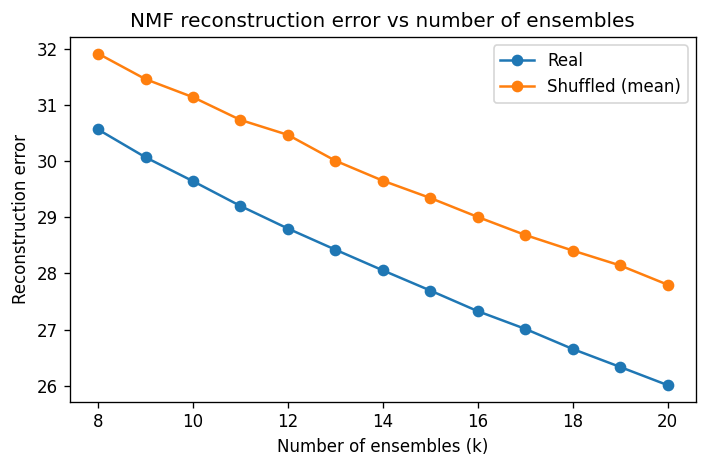

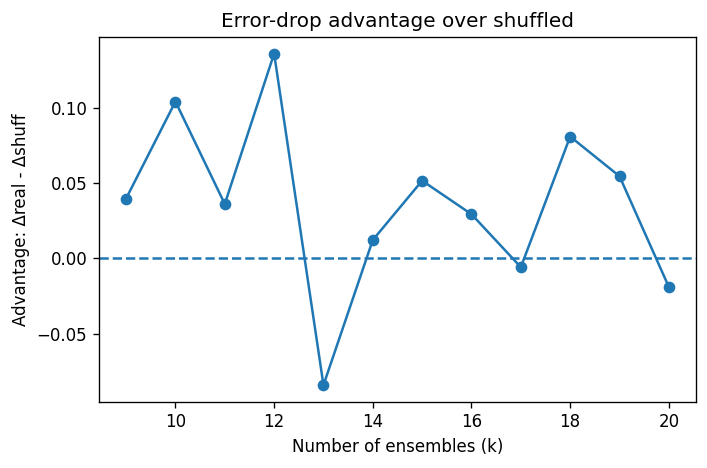

  → best_k = 12, A.shape = (300, 171)


In [70]:
# ============================================================
# CELL 10 — RUN NMF ON EACH TRACE FILE (POS / NEG, A / B)
# ============================================================

nmf_results = {}

for group_name, proc in [
    ("positive", positive_processed_traces),
    ("negative", negative_processed_traces),
]:
    group_res = {}
    print(f"\n============================")
    print(f" NMF for group: {group_name}")
    print(f"============================")

    for trace_key, df_proc in proc.items():
        print(f"\n--- {group_name} – {trace_key} ---")
        A = df_proc.values
        neuron_labels = np.array(df_proc.columns)

        best_k, ks, real_err, shuff_err = choose_n_ensembles_by_recon_error(
            A,
            k_min=8,   # explicitly set here (optional, matches defaults)
            k_max=20,
            n_shuffles=5,
            random_state=42,
        )

        W, H, err, model = fit_nmf(A, best_k, random_state=123)

        ensembles = extract_ensembles_from_H(
            H,
            neuron_labels=neuron_labels,
            top_n=15,  # top 15 neurons per ensemble
        )

        group_res[trace_key] = {
            "A": A,
            "W": W,
            "H": H,
            "best_k": best_k,
            "real_err": real_err,
            "shuff_err": shuff_err,
            "ensembles": ensembles,
        }

        print(f"  → best_k = {best_k}, A.shape = {A.shape}")

    nmf_results[group_name] = group_res


In [71]:
# ============================================================
# HELPER: RASTER PLOT GROUPED BY ENSEMBLE
# ============================================================

def plot_ensemble_raster(group_name, trace_key, nmf_results, processed_traces_dict,
                         vmax=None, cmap="viridis"):
    """
    Make a raster (heatmap) of normalized activity for one trace file,
    with neurons ordered by their primary ensemble (argmax over H),
    and dashed lines separating ensembles.
    """
    # Get NMF result and processed traces
    res = nmf_results[group_name][trace_key]
    H = res["H"]           # shape: (k, N)
    k, N = H.shape

    df_proc = processed_traces_dict[trace_key]   # time x neurons, normalized
    A = df_proc.values                           # T x N
    time = df_proc.index.values

    # ----- Assign each neuron to its primary ensemble -----
    primary_ens = H.argmax(axis=0)  # length N, values in [0..k-1]

    # Build ordering: for each ensemble, sort neurons by weight within that ensemble
    ordered_indices = []
    ens_boundaries = []  # y positions where ensembles end
    ens_sizes = []

    for e in range(k):
        members = np.where(primary_ens == e)[0]
        if members.size == 0:
            continue
        weights = H[e, members]
        sort_idx = members[np.argsort(weights)[::-1]]  # descending by weight
        ordered_indices.extend(sort_idx.tolist())
        ens_sizes.append(len(sort_idx))
        ens_boundaries.append(len(ordered_indices))

    ordered_indices = np.array(ordered_indices)

    # Reorder activity matrix
    A_sorted = A[:, ordered_indices]    # still T x N
    A_plot = A_sorted.T                 # N x T  (rows = neurons for imshow)

    # ----- Plot -----
    plt.figure(figsize=(12, 6))
    im = plt.imshow(
        A_plot,
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        cmap=cmap,
        vmax=vmax,
    )
    plt.colorbar(im, label="Normalized activity (0–1 per neuron)")
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron (grouped by ensemble)")
    plt.title(f"{group_name.capitalize()} – {trace_key}: neurons grouped by ensemble")

    # Dashed lines between ensembles
    cum = 0
    for boundary in ens_boundaries[:-1]:  # skip final boundary at top
        plt.axhline(boundary - 0.5, color="w", linestyle="--", linewidth=1)

    plt.tight_layout()
    plt.show()

    # Optionally print ensemble sizes
    print(f"{group_name} – {trace_key}:")
    print("  Ensembles (in plot order) sizes:", ens_sizes)


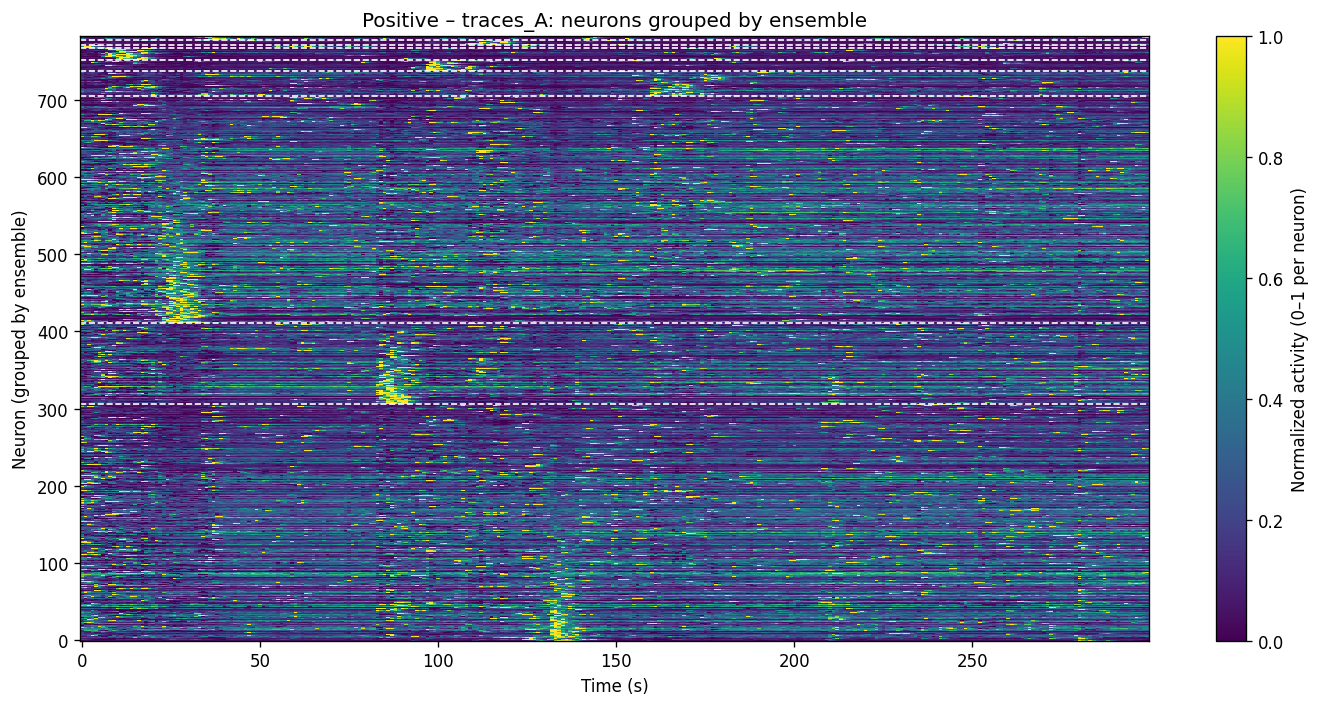

positive – traces_A:
  Ensembles (in plot order) sizes: [307, 104, 294, 33, 14, 15, 4, 7, 5]


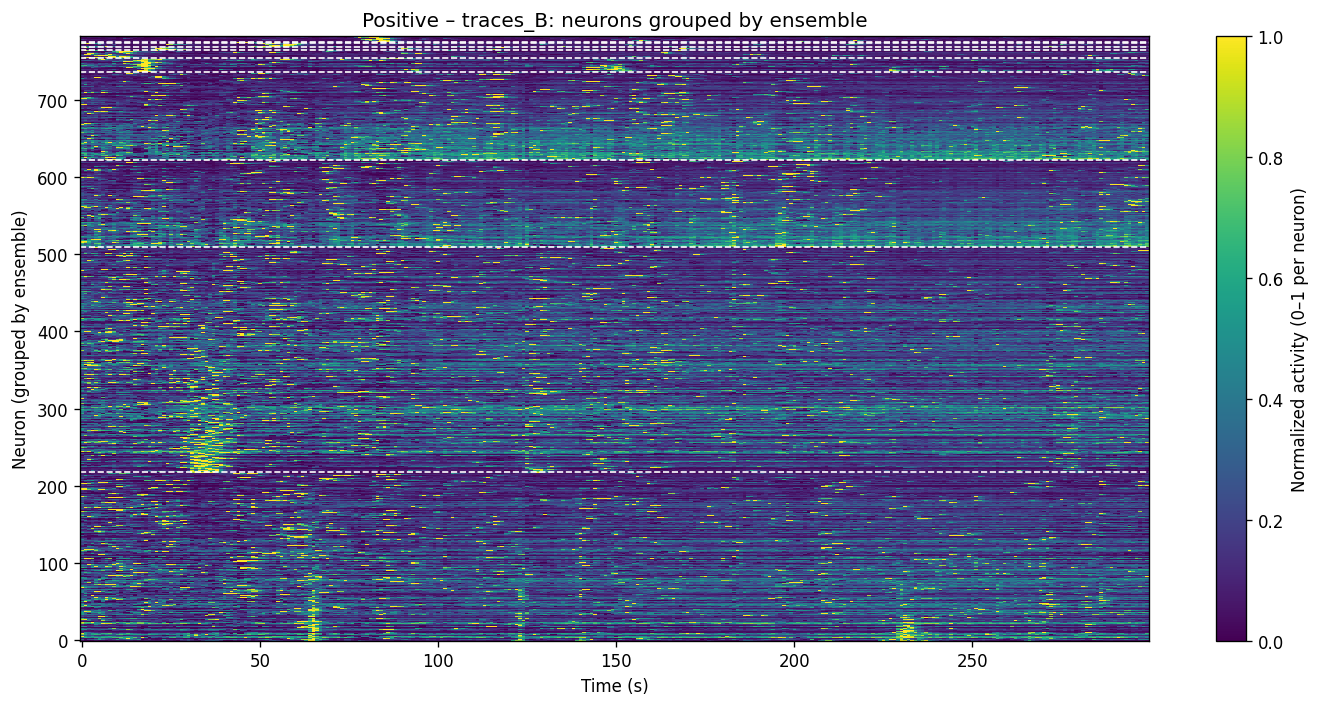

positive – traces_B:
  Ensembles (in plot order) sizes: [218, 292, 112, 115, 17, 11, 4, 5, 1, 8]


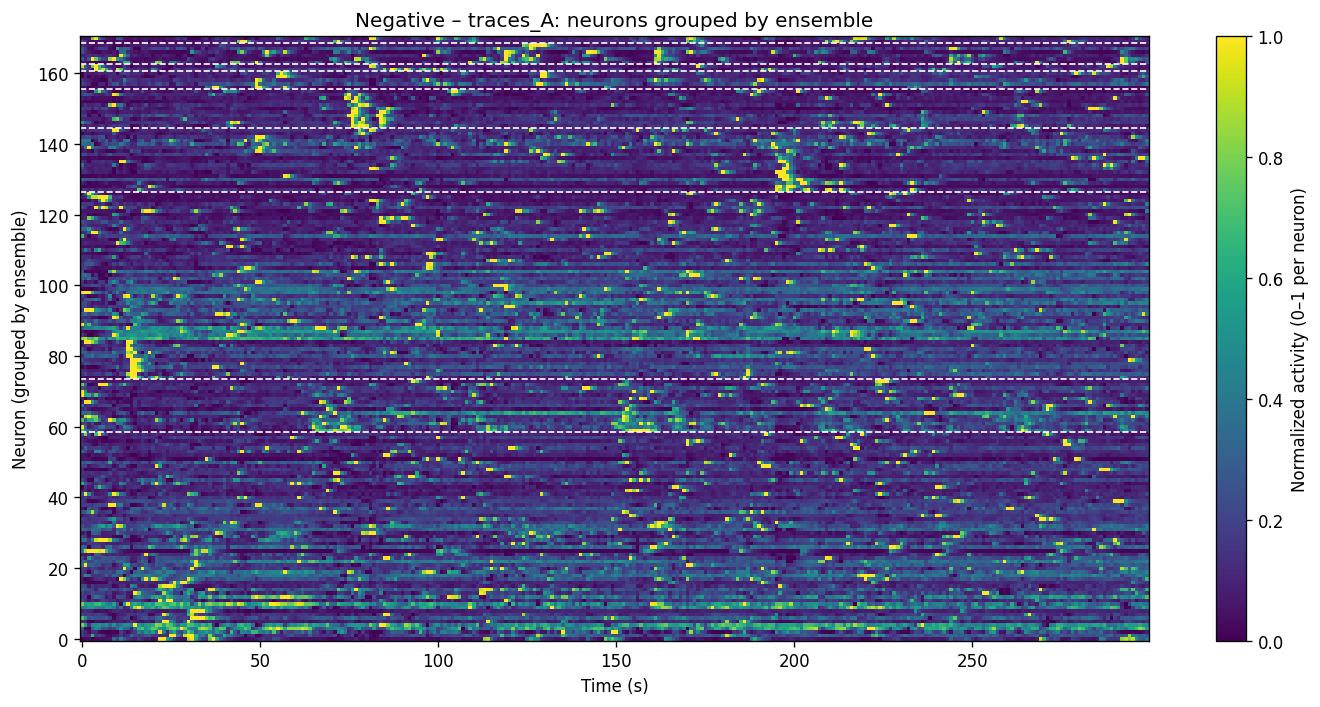

negative – traces_A:
  Ensembles (in plot order) sizes: [59, 15, 53, 18, 11, 5, 2, 6, 2]


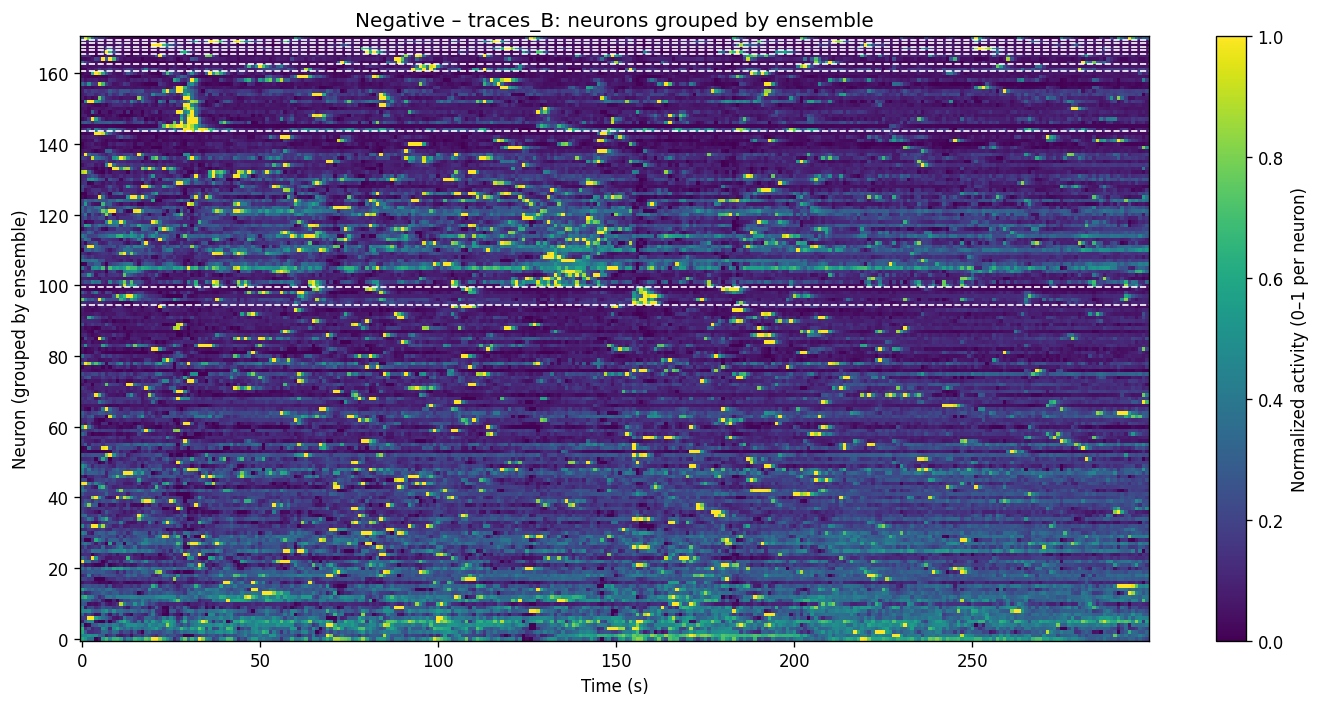

negative – traces_B:
  Ensembles (in plot order) sizes: [95, 5, 44, 17, 2, 3, 1, 1, 1, 1, 1]


In [72]:
# ============================================================
# RASTER PLOTS FOR ALL TRACE FILES (POS / NEG × A / B)
# ============================================================

for group_name, proc in [
    ("positive", positive_processed_traces),
    ("negative", negative_processed_traces),
]:
    for trace_key in proc.keys():  # "traces_A", "traces_B"
        if group_name not in nmf_results or trace_key not in nmf_results[group_name]:
            print(f"Skipping {group_name} – {trace_key}: no NMF result.")
            continue

        plot_ensemble_raster(
            group_name=group_name,
            trace_key=trace_key,
            nmf_results=nmf_results,
            processed_traces_dict=proc,
            vmax=1.0,           # you can remove or tweak this if you want auto scaling
            cmap="viridis",     # change colormap if you prefer
        )


OVERLAY ---------------------------------------------------------------------------------------------

In [73]:
# ============================================================
# RASTER + FREEZING (TOP) + FREEZE TRACE (BOTTOM)
# ============================================================

def compute_freezing_bins(freeze_df, interval_sec, n_timebins):
    """
    Convert raw freezing time-series into per-bin freezing indicator
    aligned with the downsampled traces.
    """
    if freeze_df is None:
        return np.zeros(n_timebins, dtype=bool)

    f = freeze_df.copy()
    time_col = f.columns[0]
    freezing_col = f.columns[-1]

    # Assign each sample to a bin
    f["bin"] = (f[time_col] // interval_sec).astype(int)

    # Determine freezing per bin (>50% freeze)
    freeze_bin = f.groupby("bin")[freezing_col].mean()

    freeze_vec = np.zeros(n_timebins, dtype=bool)
    for b, val in freeze_bin.items():
        if 0 <= b < n_timebins:
            freeze_vec[b] = val > 0.5

    return freeze_vec



def plot_ensemble_raster_with_freezing(group_name,
                                       trace_key,
                                       nmf_results,
                                       processed_traces_dict,
                                       raw_group_data,
                                       interval_sec=1.0,
                                       vmax=1.0,
                                       cmap="viridis"):
    """
    Raster plot of sorted neurons + ensemble boundaries +
    freezing shading + freeze trace on bottom.
    """

    # ----- Load NMF results -----
    res = nmf_results[group_name][trace_key]
    H = res["H"]           # (k, N)
    k, N = H.shape

    df_proc = processed_traces_dict[trace_key]   # T × N
    A = df_proc.values
    T = A.shape[0]

    # Load freezing data
    freeze_key = "freeze_A" if trace_key == "traces_A" else "freeze_B"
    freeze_df = raw_group_data.get(freeze_key, None)
    freeze_vec = compute_freezing_bins(freeze_df, interval_sec, T)

    # ---- Assign neurons to ensembles ----
    primary_ens = H.argmax(axis=0)

    ordered_indices = []
    ens_boundaries = []
    ens_sizes = []

    for e in range(k):
        members = np.where(primary_ens == e)[0]
        if len(members) == 0:
            continue

        weights = H[e, members]
        sorted_members = members[np.argsort(weights)[::-1]]

        ordered_indices.extend(sorted_members.tolist())
        ens_sizes.append(len(sorted_members))
        ens_boundaries.append(len(ordered_indices))

    ordered_indices = np.array(ordered_indices)
    A_sorted = A[:, ordered_indices]
    A_plot = A_sorted.T    # N × T

    # ============================================================
    # FIGURE: Top = Raster, Bottom = Freeze Trace
    # ============================================================

    fig = plt.figure(figsize=(12, 7))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[6, 1], hspace=0.08)

    # ------------------ RASTER (TOP) ------------------
    ax_raster = fig.add_subplot(gs[0])

    ax_raster.imshow(
        A_plot,
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        cmap=cmap,
        vmax=vmax,
    )

    ax_raster.set_title(f"{group_name.capitalize()} – {trace_key}")
    ax_raster.set_ylabel("Neuron (by ensemble)")
    ax_raster.set_xticks([])

    # Dashed lines between ensembles
    for boundary in ens_boundaries[:-1]:
        ax_raster.axhline(boundary - 0.5, color="white", linestyle="--", linewidth=1)

    # Shade freezing intervals
    padded = np.pad(freeze_vec.astype(int), (1, 1), constant_values=0)
    diff = np.diff(padded)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0] - 1

    for s, e in zip(starts, ends):
        ax_raster.axvspan(s - 0.5, e + 0.5, color="black", alpha=0.15)

    # ------------------ FREEZE TRACE (BOTTOM) ------------------
    ax_freeze = fig.add_subplot(gs[1], sharex=ax_raster)

    # x-axis is still bin index, but we'll relabel as time (s)
    x_bins = np.arange(T)

    ax_freeze.fill_between(
        x_bins,
        0,
        freeze_vec.astype(float),
        step="mid",
        color="black",
        alpha=0.9
    )

    ax_freeze.set_ylim(0, 1.05)
    ax_freeze.set_ylabel("Freeze")
    ax_freeze.set_xlabel("Time (s)")
    ax_freeze.set_yticks([0, 1])
    ax_freeze.set_yticklabels(["0", "1"])
    ax_freeze.grid(False)

    # Ensure x-axis alignment
    ax_freeze.set_xlim(ax_raster.get_xlim())

    # --- Relabel x-ticks from bin index → time (s) ---
    xticks = ax_freeze.get_xticks()
    # Keep ticks within [0, T-1]
    xticks = xticks[(xticks >= 0) & (xticks <= T-1)]
    ax_freeze.set_xticks(xticks)
    ax_freeze.set_xticklabels([f"{t * interval_sec:.0f}" for t in xticks])

    # Clean up visuals
    for spine in ["top", "right"]:
        ax_raster.spines[spine].set_visible(False)
        ax_freeze.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(f"{group_name} – {trace_key}:")
    print("  Ensemble sizes:", ens_sizes)
    print("  Freezing bins:", freeze_vec.sum(), "/", T)



=== Plotting positive – traces_A ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\1226666926.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


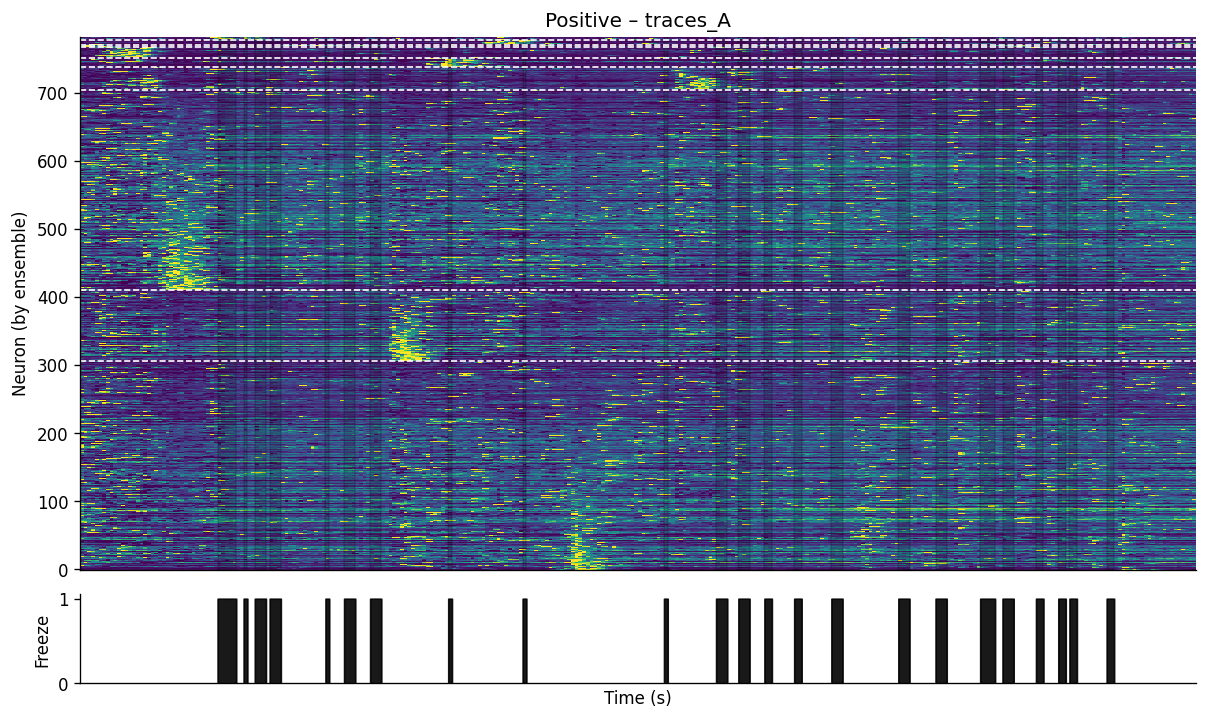

positive – traces_A:
  Ensemble sizes: [307, 104, 294, 33, 14, 15, 4, 7, 5]
  Freezing bins: 56 / 300

=== Plotting positive – traces_B ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\1226666926.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


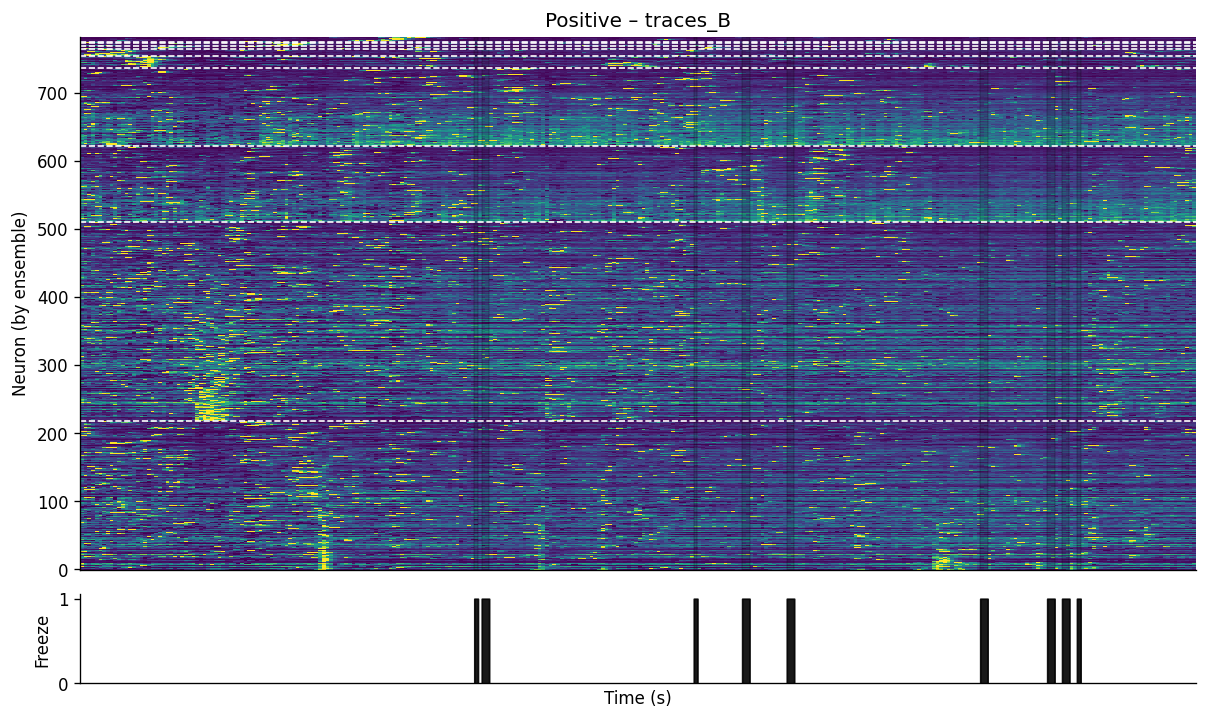

C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\1226666926.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


positive – traces_B:
  Ensemble sizes: [218, 292, 112, 115, 17, 11, 4, 5, 1, 8]
  Freezing bins: 15 / 300

=== Plotting negative – traces_A ===


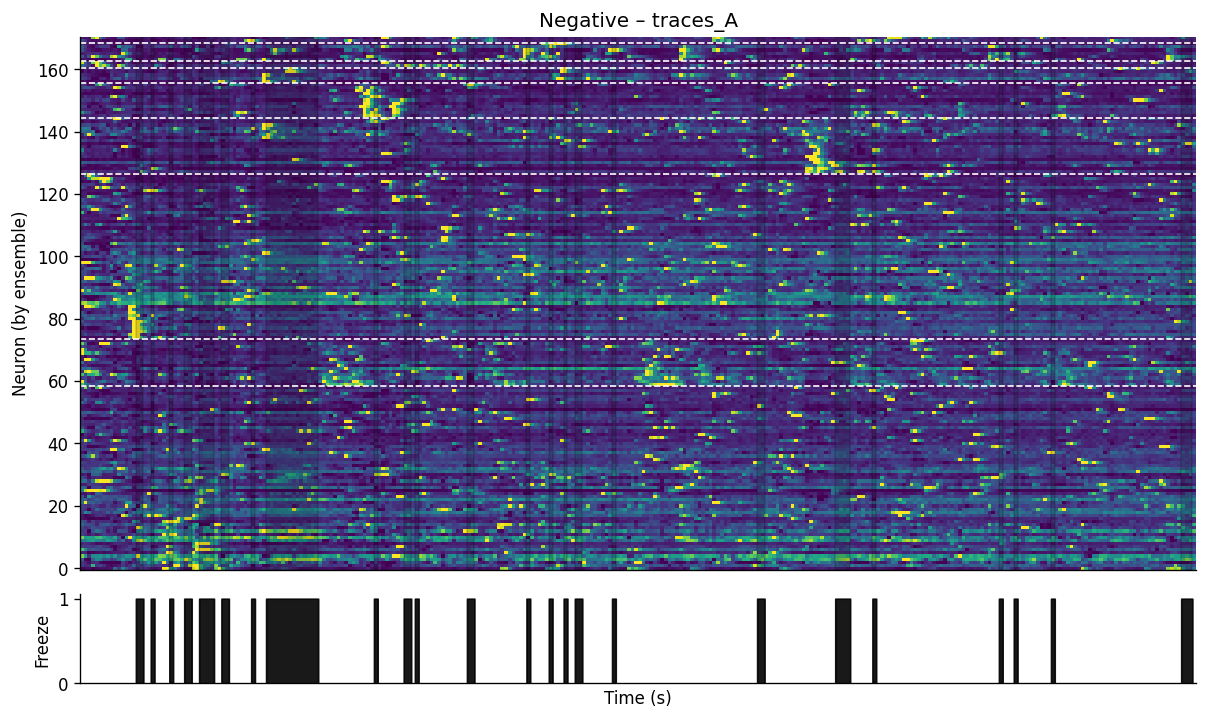

negative – traces_A:
  Ensemble sizes: [59, 15, 53, 18, 11, 5, 2, 6, 2]
  Freezing bins: 52 / 300

=== Plotting negative – traces_B ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\1226666926.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


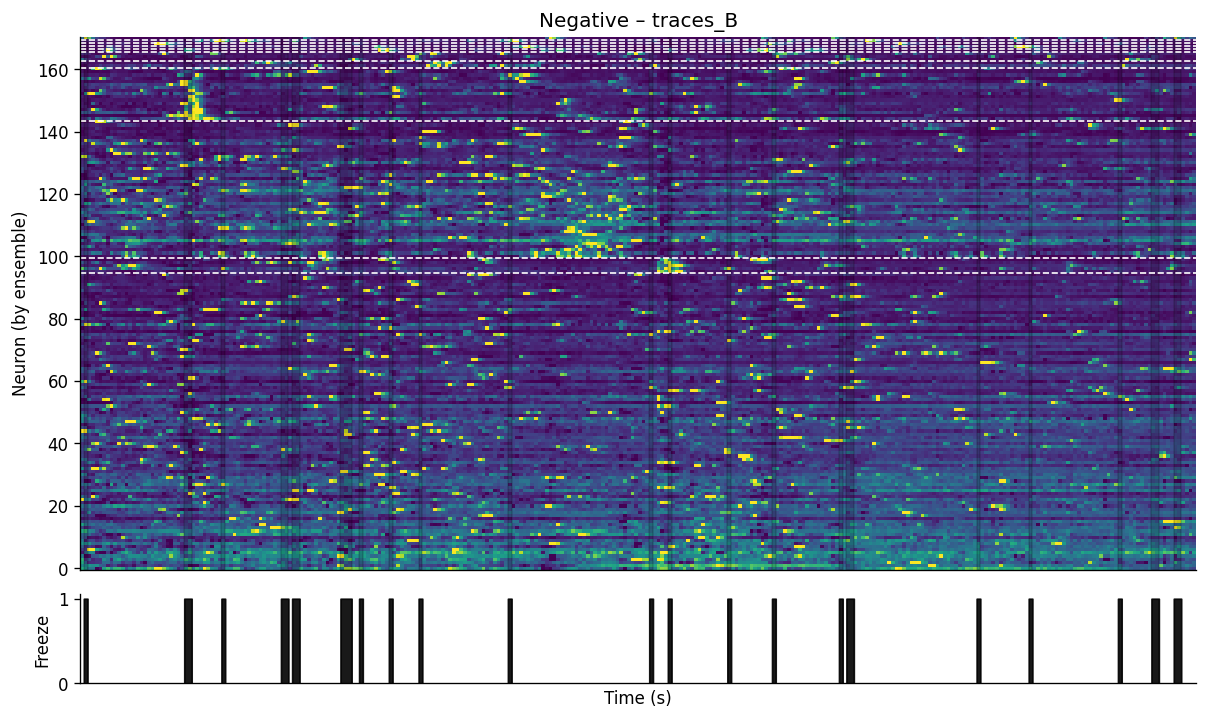

negative – traces_B:
  Ensemble sizes: [95, 5, 44, 17, 2, 3, 1, 1, 1, 1, 1]
  Freezing bins: 29 / 300


In [74]:
# ============================================================
# MAKE RASTER + FREEZE PLOTS FOR ALL TRACE FILES
# ============================================================

for group_name, proc_traces, raw_group in [
    ("positive", positive_processed_traces, positive_data),
    ("negative", negative_processed_traces, negative_data),
]:
    for trace_key in proc_traces.keys():  # typically "traces_A", "traces_B"
        if group_name not in nmf_results or trace_key not in nmf_results[group_name]:
            print(f"Skipping {group_name} – {trace_key}: no NMF result.")
            continue

        print(f"\n=== Plotting {group_name} – {trace_key} ===")
        plot_ensemble_raster_with_freezing(
            group_name=group_name,
            trace_key=trace_key,
            nmf_results=nmf_results,
            processed_traces_dict=proc_traces,
            raw_group_data=raw_group,
            interval_sec=DOWNSAMPLE_INTERVAL_SEC,  # 1.0 s
            vmax=1.0,
            cmap="viridis",
        )


Events Plots ------------------------------------------------

In [75]:
# ============================================================
# EVENTS → BINNED MATRIX + RASTER (WITH SAME ENSEMBLES)
# ============================================================

def build_event_matrix(events_df, interval_sec, n_timebins, neuron_labels):
    """
    Convert events CSV into a [time_bin x neuron] matrix, using neuron
    labels (e.g., 'C0001') to map events to the correct columns.

    Assumptions:
      - events_df.columns[0] = time (s)
      - events_df.columns[1] = neuron label (e.g., 'C0208', possibly with spaces)
      - neuron_labels = list/array of column names from the traces DataFrame.
    """
    n_neurons = len(neuron_labels)
    mat = np.zeros((n_timebins, n_neurons), dtype=float)

    if events_df is None or len(events_df) == 0:
        return mat

    f = events_df.copy()
    time_col = f.columns[0]
    neuron_col = f.columns[1]

    # Clean neuron labels in the events file: strip spaces, ensure string
    f[neuron_col] = f[neuron_col].astype(str).str.strip()

    # Map neuron label -> index in traces
    label_to_idx = {lab: i for i, lab in enumerate(neuron_labels)}

    # Keep only events with labels that exist in traces
    mask_has_label = f[neuron_col].isin(label_to_idx.keys())
    f = f[mask_has_label]

    if f.empty:
        return mat

    # Bin times
    f["bin"] = (f[time_col].astype(float) // interval_sec).astype(int)

    # Keep bins in valid range
    mask_in_range = (f["bin"] >= 0) & (f["bin"] < n_timebins)
    f = f[mask_in_range]

    if f.empty:
        return mat

    bins = f["bin"].to_numpy()
    neuron_idx = f[neuron_col].map(label_to_idx).to_numpy()

    # Accumulate counts per (bin, neuron)
    np.add.at(mat, (bins, neuron_idx), 1.0)

    return mat


def plot_ensemble_events_raster_with_freezing(group_name,
                                              trace_key,
                                              nmf_results,
                                              processed_traces_dict,
                                              raw_group_data,
                                              interval_sec=1.0,
                                              vmax=None,
                                              cmap="viridis"):
    """
    Same layout as the trace-based raster, but uses EVENTS as the signal.

    - Ensembles (H) and neuron ordering come from NMF on traces.
    - events_A / events_B are used as the underlying data.
    - Freezing overlay and freeze trace are included.
    """

    # ----- NMF + trace info -----
    res = nmf_results[group_name][trace_key]
    H = res["H"]                  # (k, N)
    k, N = H.shape

    df_traces = processed_traces_dict[trace_key]  # T × N
    T = df_traces.shape[0]
    neuron_labels = df_traces.columns.to_numpy()

    # ----- Pick the right events file -----
    events_key = "events_A" if trace_key == "traces_A" else "events_B"
    events_df = raw_group_data.get(events_key, None)

    # Build [T x N] event-count matrix
    A_events = build_event_matrix(events_df, interval_sec, T, neuron_labels)  # T × N

    # Choose vmax if not specified (for color scaling)
    if vmax is None:
        vmax = np.percentile(A_events, 99)
        if vmax <= 0:
            vmax = 1.0

    # ----- Freezing vector -----
    freeze_key = "freeze_A" if trace_key == "traces_A" else "freeze_B"
    freeze_df = raw_group_data.get(freeze_key, None)
    freeze_vec = compute_freezing_bins(freeze_df, interval_sec, T)

    # ----- Ensemble-based neuron ordering (same as traces) -----
    primary_ens = H.argmax(axis=0)

    ordered_indices = []
    ens_boundaries = []
    ens_sizes = []

    for e in range(k):
        members = np.where(primary_ens == e)[0]
        if len(members) == 0:
            continue

        weights = H[e, members]
        sorted_members = members[np.argsort(weights)[::-1]]

        ordered_indices.extend(sorted_members.tolist())
        ens_sizes.append(len(sorted_members))
        ens_boundaries.append(len(ordered_indices))

    ordered_indices = np.array(ordered_indices)

    # Reorder event matrix by ensemble
    A_sorted = A_events[:, ordered_indices]  # T × N
    A_plot = A_sorted.T                      # N × T

    # ============================================================
    # FIGURE: Top = Events Raster, Bottom = Freeze Trace
    # ============================================================

    fig = plt.figure(figsize=(12, 7))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[6, 1], hspace=0.08)

    # ------------------ TOP: EVENTS RASTER ------------------
    ax_raster = fig.add_subplot(gs[0])

    ax_raster.imshow(
        A_plot,
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        cmap=cmap,
        vmax=vmax,
    )

    ax_raster.set_title(f"{group_name.capitalize()} – {trace_key} (events)")
    ax_raster.set_ylabel("Neuron (by ensemble)")
    ax_raster.set_xticks([])

    # Dashed lines between ensembles
    for boundary in ens_boundaries[:-1]:
        ax_raster.axhline(boundary - 0.5, color="white", linestyle="--", linewidth=1)

    # Shade freezing intervals
    padded = np.pad(freeze_vec.astype(int), (1, 1), constant_values=0)
    diff = np.diff(padded)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0] - 1

    for s, e in zip(starts, ends):
        ax_raster.axvspan(s - 0.5, e + 0.5, color="black", alpha=0.15)

    # ------------------ BOTTOM: FREEZE TRACE ------------------
    ax_freeze = fig.add_subplot(gs[1], sharex=ax_raster)

    ax_freeze.fill_between(
        np.arange(T),
        0,
        freeze_vec.astype(float),
        step="mid",
        color="black",
        alpha=0.9
    )

    ax_freeze.set_ylim(0, 1.05)
    ax_freeze.set_ylabel("Freeze")
    ax_freeze.set_xlabel("Time (1s bins)")
    ax_freeze.set_yticks([0, 1])
    ax_freeze.set_yticklabels(["0", "1"])
    ax_freeze.grid(False)

    # Clean up visuals
    for spine in ["top", "right"]:
        ax_raster.spines[spine].set_visible(False)
        ax_freeze.spines[spine].set_visible(False)

    # Ensure x-axis alignment
    ax_freeze.set_xlim(ax_raster.get_xlim())

    plt.tight_layout()
    plt.show()

    print(f"{group_name} – {trace_key} (events):")
    print("  Ensemble sizes (same as traces):", ens_sizes)
    print("  Freezing bins:", freeze_vec.sum(), "/", T)



=== EVENTS PLOT: positive – traces_A ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\2468761897.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


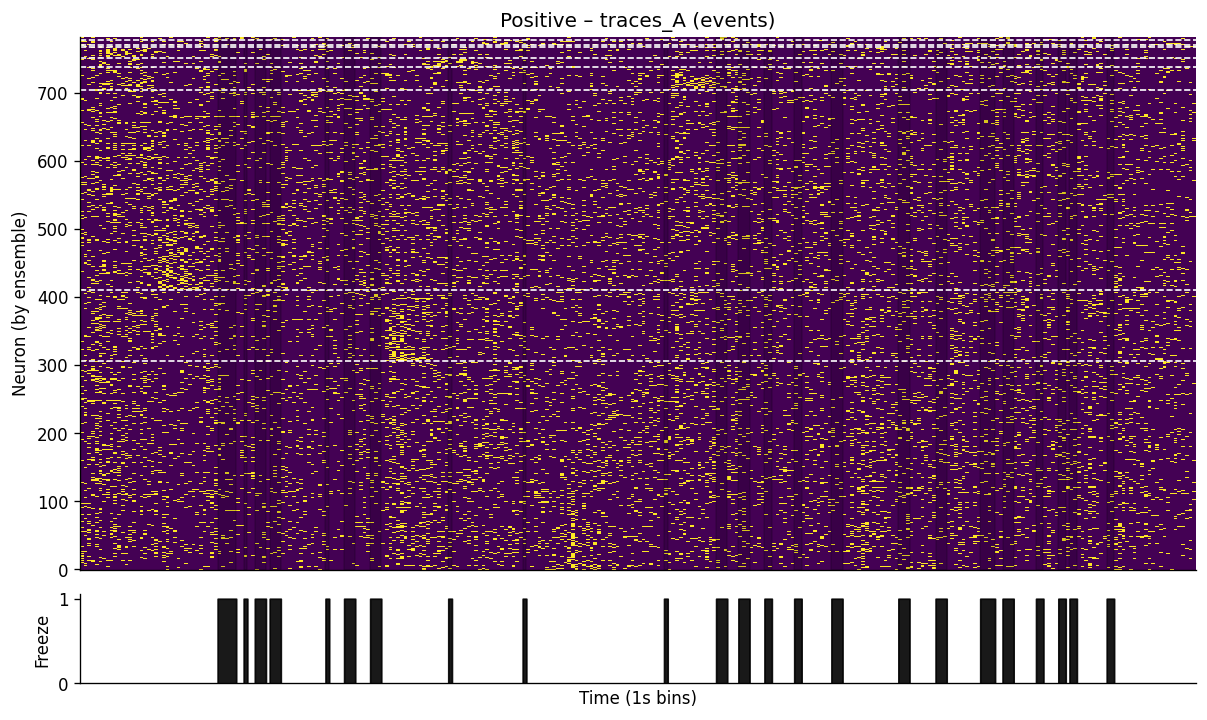

positive – traces_A (events):
  Ensemble sizes (same as traces): [307, 104, 294, 33, 14, 15, 4, 7, 5]
  Freezing bins: 56 / 300

=== EVENTS PLOT: positive – traces_B ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\2468761897.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


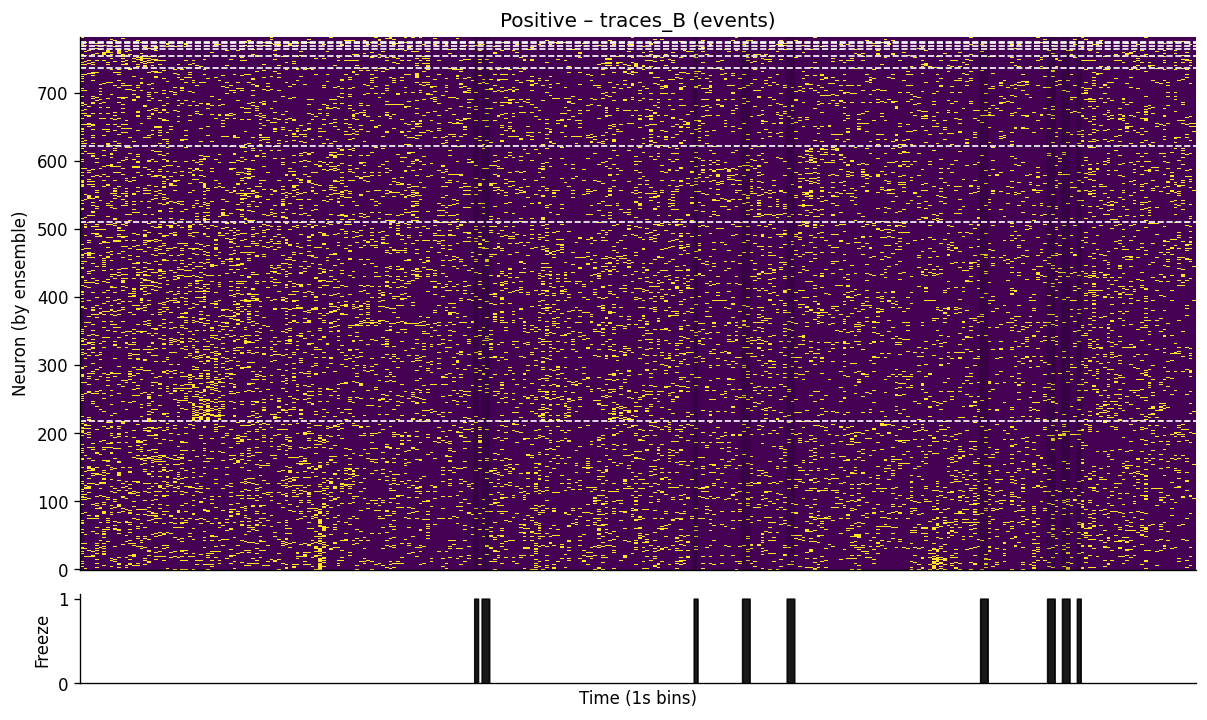

positive – traces_B (events):
  Ensemble sizes (same as traces): [218, 292, 112, 115, 17, 11, 4, 5, 1, 8]
  Freezing bins: 15 / 300

=== EVENTS PLOT: negative – traces_A ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\2468761897.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


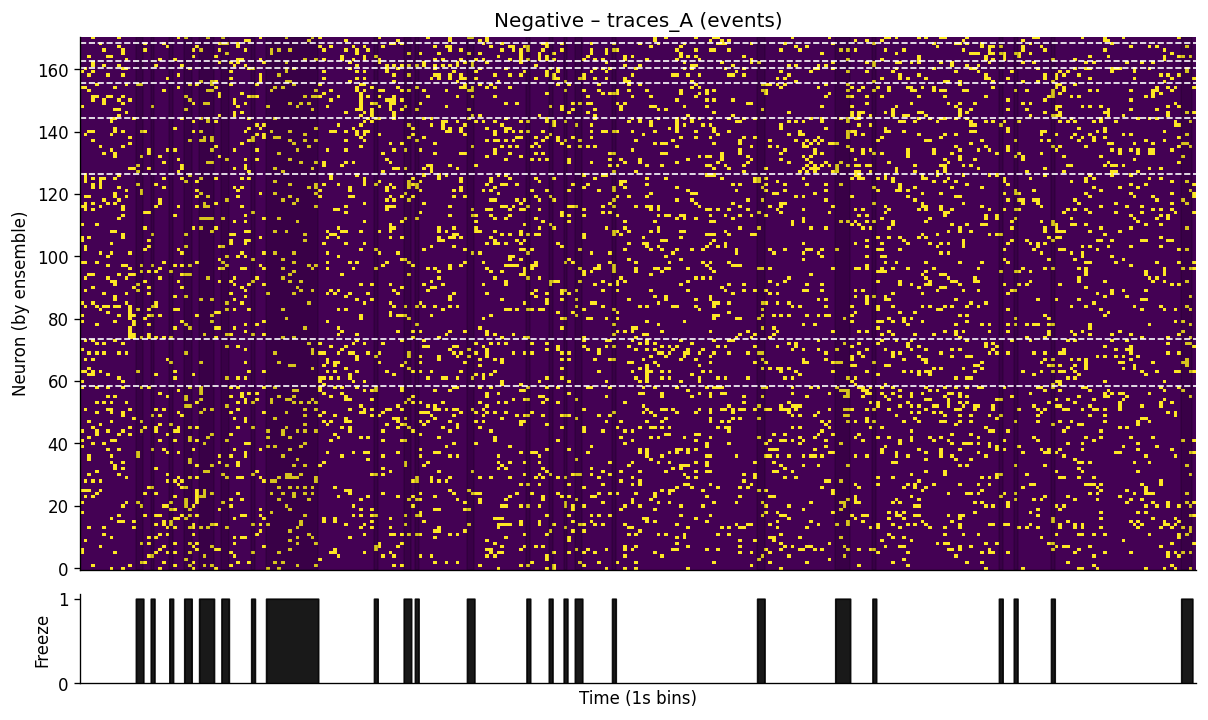

negative – traces_A (events):
  Ensemble sizes (same as traces): [59, 15, 53, 18, 11, 5, 2, 6, 2]
  Freezing bins: 52 / 300

=== EVENTS PLOT: negative – traces_B ===


C:\Users\sina7\AppData\Local\Temp\ipykernel_8208\2468761897.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


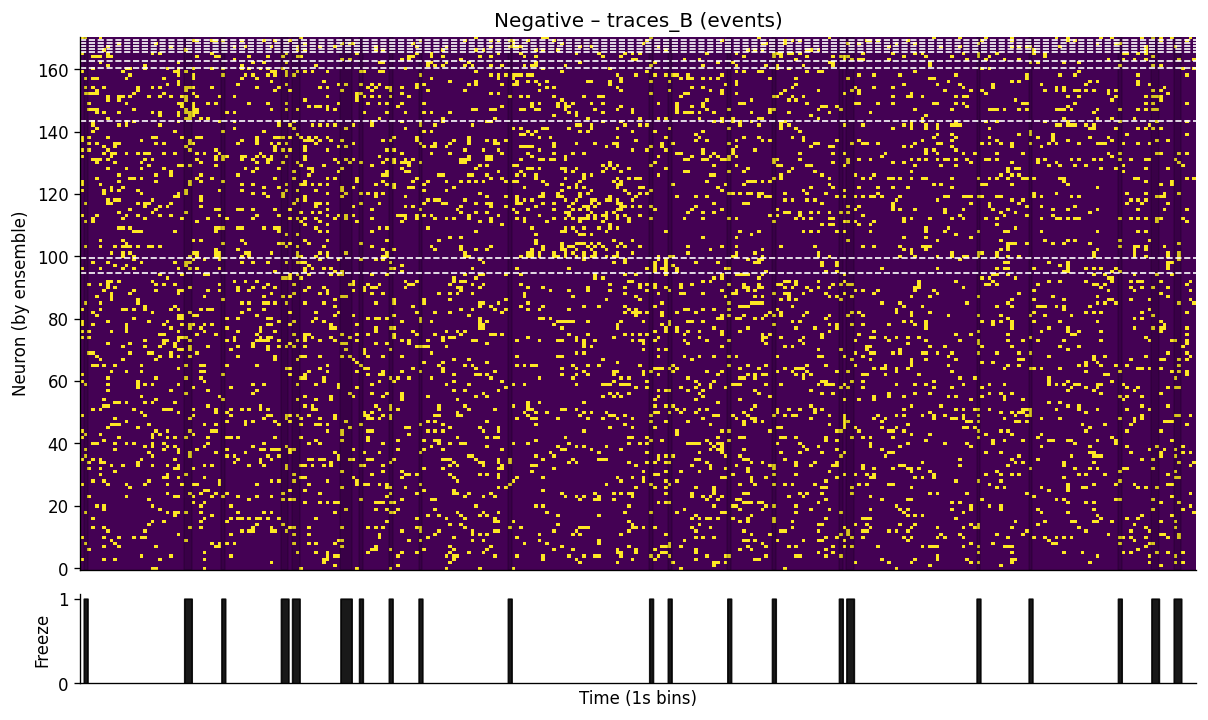

negative – traces_B (events):
  Ensemble sizes (same as traces): [95, 5, 44, 17, 2, 3, 1, 1, 1, 1, 1]
  Freezing bins: 29 / 300


In [76]:
# ============================================================
# EVENTS RASTERS FOR ALL TRACE FILES (POS / NEG × A / B)
# ============================================================

for group_name, proc_traces, raw_group in [
    ("positive", positive_processed_traces, positive_data),
    ("negative", negative_processed_traces, negative_data),
]:
    for trace_key in proc_traces.keys():  # usually "traces_A", "traces_B"
        if group_name not in nmf_results or trace_key not in nmf_results[group_name]:
            print(f"Skipping {group_name} – {trace_key}: no NMF result.")
            continue

        print(f"\n=== EVENTS PLOT: {group_name} – {trace_key} ===")
        plot_ensemble_events_raster_with_freezing(
            group_name=group_name,
            trace_key=trace_key,
            nmf_results=nmf_results,
            processed_traces_dict=proc_traces,
            raw_group_data=raw_group,
            interval_sec=DOWNSAMPLE_INTERVAL_SEC,  # 1.0 s
            cmap="viridis",
        )



 ENSEMBLE STABILITY ANALYSIS — POSITIVE GROUP

Adjusted Rand Index (ARI): 0.0088

Contingency Matrix (# neurons in each A–B ensemble pair):


B_0  B_1  B_2  B_3  B_4  B_5  B_6  B_7  B_8  B_9
A_0    91  113   50   39    6    3    2    0    0    3
A_1    25   47   16   12    2    1    1    0    0    0
A_2    82  111   34   51    6    4    0    2    1    3
A_3     9    9    3    9    0    1    0    1    0    1
A_4     6    2    1    1    1    2    0    1    0    0
A_5     3    3    4    1    2    0    1    1    0    0
A_6     1    1    1    0    0    0    0    0    0    1
A_7     1    3    2    1    0    0    0    0    0    0
A_8     0    0    0    0    0    0    0    0    0    0
A_9     0    3    1    1    0    0    0    0    0    0
A_10    0    0    0    0    0    0    0    0    0    0

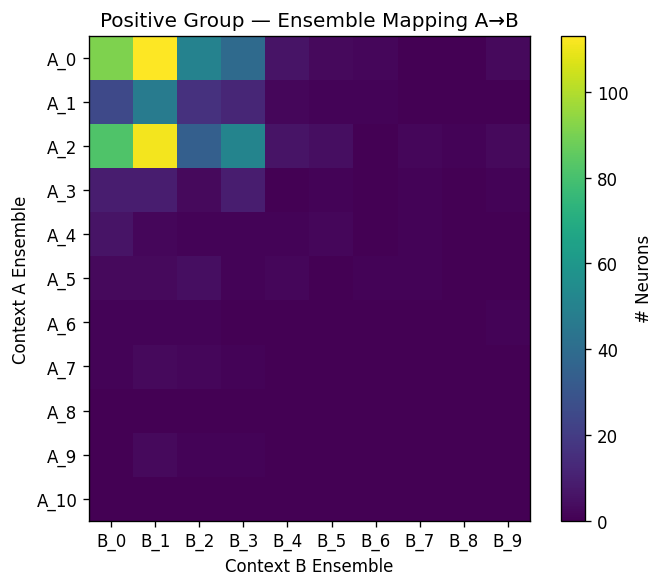


 ENSEMBLE STABILITY ANALYSIS — NEGATIVE GROUP

Adjusted Rand Index (ARI): 0.0324

Contingency Matrix (# neurons in each A–B ensemble pair):


B_0  B_1  B_2  B_3  B_4  B_5  B_6  B_7  B_8  B_9  B_10  B_11
A_0    37    1   15    3    0    0    0    0    1    1     0     1
A_1     9    0    4    2    0    0    0    0    0    0     0     0
A_2    31    2    9    8    1    1    1    0    0    0     0     0
A_3     5    2    9    2    0    0    0    0    0    0     0     0
A_4     5    0    3    1    1    1    0    0    0    0     0     0
A_5     3    0    1    0    0    1    0    0    0    0     0     0
A_6     1    0    1    0    0    0    0    0    0    0     0     0
A_7     3    0    2    0    0    0    0    1    0    0     0     0
A_8     0    0    0    0    0    0    0    0    0    0     0     0
A_9     1    0    0    1    0    0    0    0    0    0     0     0
A_10    0    0    0    0    0    0    0    0    0    0     0     0
A_11    0    0    0    0    0    0    0    0    0    0     0     0
A_12    0    0    0    0    0    0    0    0    0    0     0     0

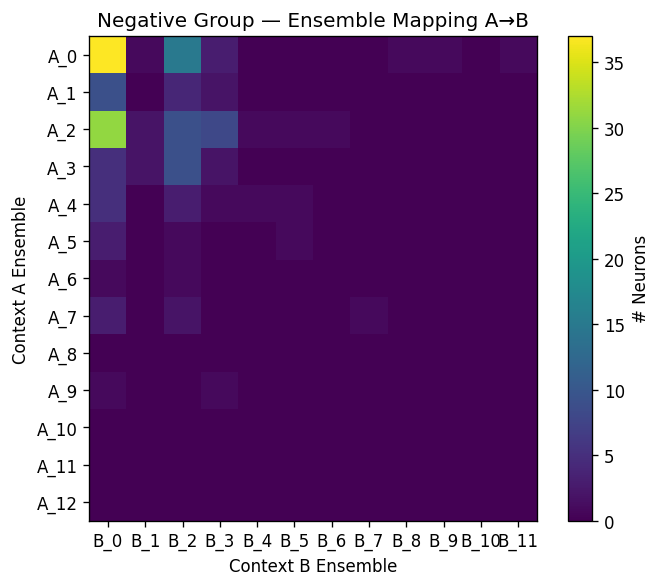


================ COMPARISON SUMMARY ================
Positive group ARI: 0.0088
Negative group ARI: 0.0324

→ The NEGATIVE group shows MORE ensemble stability across contexts.


In [79]:
# ============================================================
# METHOD 1 — Contingency Matrix & Adjusted Rand Index
# Compare ensemble stability between Context A and B
# For Positive and Negative groups
# ============================================================

from sklearn.metrics import adjusted_rand_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_ari_and_contingency(nmf_results, group_name):
    """
    Computes:
      - Ensemble labels in A and B
      - Contingency matrix (# neurons in each cross-ensemble pair)
      - Adjusted Rand Index (ARI)
    """
    # Extract NMF H matrices
    H_A = nmf_results[group_name]["traces_A"]["H"]
    H_B = nmf_results[group_name]["traces_B"]["H"]

    # Primary ensemble assignments: argmax over the ensemble axis
    labels_A = np.argmax(H_A, axis=0)   # length N (neurons)
    labels_B = np.argmax(H_B, axis=0)   # length N
    
    # Compute ARI
    ari = adjusted_rand_score(labels_A, labels_B)

    # Build contingency matrix
    kA = H_A.shape[0]
    kB = H_B.shape[0]

    contingency = np.zeros((kA, kB), dtype=int)
    for i in range(len(labels_A)):
        contingency[labels_A[i], labels_B[i]] += 1

    contingency_df = pd.DataFrame(
        contingency,
        index=[f"A_{i}" for i in range(kA)],
        columns=[f"B_{j}" for j in range(kB)]
    )

    return ari, contingency_df, labels_A, labels_B


def plot_contingency_matrix(contingency_df, title):
    """Heatmap of contingency matrix"""
    plt.figure(figsize=(6, 5))
    plt.imshow(contingency_df, cmap="viridis")
    plt.colorbar(label="# Neurons")
    plt.title(title)
    plt.xlabel("Context B Ensemble")
    plt.ylabel("Context A Ensemble")
    plt.xticks(range(contingency_df.shape[1]), contingency_df.columns)
    plt.yticks(range(contingency_df.shape[0]), contingency_df.index)
    plt.tight_layout()
    plt.show()


# ============================================================
# RUN FOR POSITIVE + NEGATIVE GROUPS
# ============================================================

results = {}

for group in ["positive", "negative"]:
    print("\n====================================================")
    print(f" ENSEMBLE STABILITY ANALYSIS — {group.upper()} GROUP")
    print("====================================================")

    ari, contingency_df, labels_A, labels_B = compute_ari_and_contingency(
        nmf_results,
        group_name=group
    )

    results[group] = {"ari": ari, "contingency": contingency_df}

    print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
    print("\nContingency Matrix (# neurons in each A–B ensemble pair):")
    display(contingency_df)

    plot_contingency_matrix(
        contingency_df,
        title=f"{group.capitalize()} Group — Ensemble Mapping A→B"
    )

# ============================================================
# COMPARE POSITIVE VS NEGATIVE GROUPS
# ============================================================

print("\n================ COMPARISON SUMMARY ================")
print(f"Positive group ARI: {results['positive']['ari']:.4f}")
print(f"Negative group ARI: {results['negative']['ari']:.4f}")

if results["positive"]["ari"] > results["negative"]["ari"]:
    print("\n→ The POSITIVE group shows MORE ensemble stability across contexts.")
elif results["positive"]["ari"] < results["negative"]["ari"]:
    print("\n→ The NEGATIVE group shows MORE ensemble stability across contexts.")
else:
    print("\n→ Both groups show equal ensemble stability.")



 ENSEMBLE CENTROID SIMILARITY — POSITIVE GROUP

Centroid Similarity Matrix (A vs B):


0         1         2         3         4         5         6  \
0   0.986097  0.985915  0.980803  0.985665  0.829054  0.766823  0.675029   
1   0.974019  0.965251  0.966750  0.969530  0.827266  0.769850  0.671943   
2   0.985177  0.991519  0.980499  0.977201  0.837475  0.763802  0.744388   
3   0.931735  0.935126  0.932640  0.939755  0.811575  0.748414  0.633381   
4   0.763748  0.777715  0.769649  0.794699  0.651865  0.631205  0.508785   
5   0.706691  0.696308  0.682613  0.679180  0.786572  0.841470  0.429996   
6   0.560126  0.532370  0.535131  0.513388  0.425435  0.637533  0.328165   
7   0.652610  0.660765  0.650941  0.682426  0.547542  0.468289  0.557078   
8        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9   0.619261  0.681065  0.602884  0.592137  0.499470  0.446093  0.414713   
10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

           7         8         9  
0   0.711018  0.709351  0.619282  
1   0.686265  0.697174  0.701913  
2   0.719090  0.706309  0.614163  
3   0.663665  0.666431  0.550746  
4   0.548654  0.565219  0.457403  
5   0.461828  0.451830  0.416527  
6   0.540746  0.338630  0.316878  
7   0.410121  0.501440  0.356096  
8        NaN       NaN       NaN  
9   0.384705  0.607160  0.338861  
10       NaN       NaN       NaN

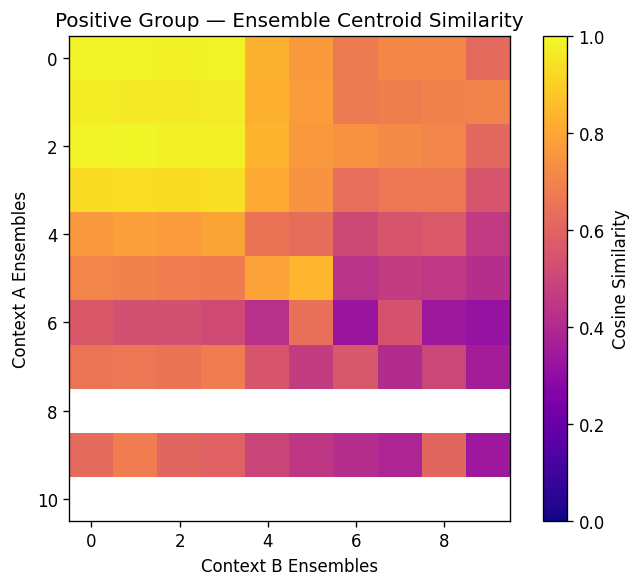


 ENSEMBLE CENTROID SIMILARITY — NEGATIVE GROUP

Centroid Similarity Matrix (A vs B):


0         1         2         3         4         5         6   \
0   0.985366  0.754592  0.962928  0.905284  0.718750  0.692956  0.427090   
1   0.946439  0.767972  0.900984  0.814532  0.669683  0.683684  0.371143   
2   0.985815  0.767031  0.966602  0.871614  0.730509  0.684146  0.419738   
3   0.934257  0.711909  0.909919  0.814087  0.698263  0.626997  0.483072   
4   0.857672  0.654455  0.810534  0.761500  0.563147  0.590122  0.411944   
5   0.873493  0.660338  0.873912  0.758462  0.692122  0.575254  0.357957   
6   0.720959  0.566642  0.698479  0.656886  0.547625  0.561734  0.362188   
7   0.806666  0.623090  0.822747  0.713121  0.576443  0.530390  0.382120   
8        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9   0.747988  0.565371  0.690883  0.605158  0.533910  0.467040  0.281771   
10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          7         8         9   10        11  
0   0.522634  0.494867  0.572693 NaN  0.434605  
1   0.478637  0.408989  0.500262 NaN  0.430972  
2   0.551100  0.464780  0.573603 NaN  0.434807  
3   0.499245  0.405923  0.530344 NaN  0.410336  
4   0.486730  0.399612  0.463241 NaN  0.344640  
5   0.450970  0.369571  0.531091 NaN  0.399597  
6   0.374879  0.307039  0.387942 NaN  0.300204  
7   0.547774  0.350092  0.463664 NaN  0.423166  
8        NaN       NaN       NaN NaN       NaN  
9   0.360845  0.332626  0.466062 NaN  0.261361  
10       NaN       NaN       NaN NaN       NaN  
11       NaN       NaN       NaN NaN       NaN  
12       NaN       NaN       NaN NaN       NaN

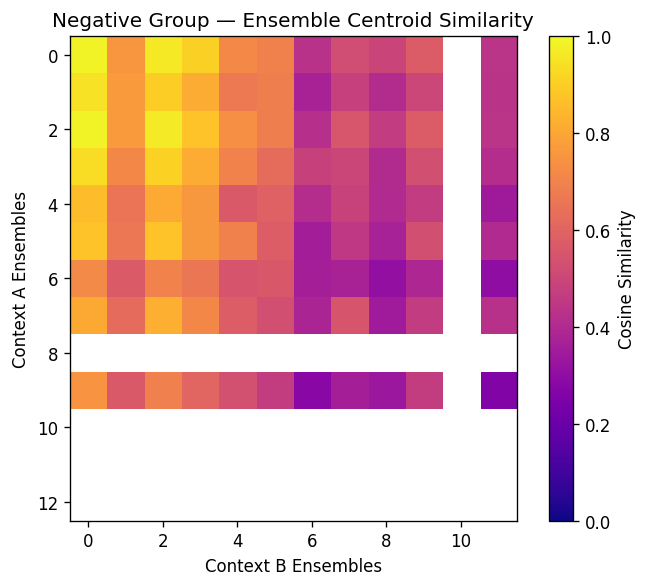

In [80]:
# ============================================================
# METHOD 2 — Ensemble Centroid Similarity (A vs B)
# For Positive and Negative groups
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm


def compute_centroids(A, labels, k):
    """
    Compute ensemble centroids.
    A = T × N processed trace matrix
    labels = ensemble index for each neuron
    k = number of ensembles
    Returns list of centroids (each is a vector length T)
    """
    centroids = []
    for i in range(k):
        members = np.where(labels == i)[0]
        if len(members) == 0:
            centroids.append(None)
        else:
            centroids.append(A[:, members].mean(axis=1))
    return centroids


def compute_similarity_matrix(centroids_A, centroids_B):
    """
    Compute cosine similarity between every pair of ensemble centroids.
    Returns kA × kB matrix.
    """
    kA = len(centroids_A)
    kB = len(centroids_B)
    sim = np.zeros((kA, kB))

    for i in range(kA):
        for j in range(kB):
            if centroids_A[i] is None or centroids_B[j] is None:
                sim[i, j] = np.nan
            else:
                v1 = centroids_A[i]
                v2 = centroids_B[j]
                sim[i, j] = np.dot(v1, v2) / (norm(v1) * norm(v2))
    return sim


def plot_similarity_matrix(sim, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(sim, cmap="plasma", vmin=0, vmax=1)
    plt.colorbar(label="Cosine Similarity")
    plt.title(title)
    plt.xlabel("Context B Ensembles")
    plt.ylabel("Context A Ensembles")
    plt.tight_layout()
    plt.show()


# ============================================================
# RUN FOR POSITIVE AND NEGATIVE GROUPS
# ============================================================

for group in ["positive", "negative"]:
    print("\n====================================================")
    print(f" ENSEMBLE CENTROID SIMILARITY — {group.upper()} GROUP")
    print("====================================================")

    # Load processed traces
    if group == "positive":
        A_proc = positive_processed_traces["traces_A"].values
        B_proc = positive_processed_traces["traces_B"].values
    else:
        A_proc = negative_processed_traces["traces_A"].values
        B_proc = negative_processed_traces["traces_B"].values

    # Load ensemble labels
    labels_A = nmf_results[group]["traces_A"]["H"].argmax(axis=0)
    labels_B = nmf_results[group]["traces_B"]["H"].argmax(axis=0)

    kA = nmf_results[group]["traces_A"]["H"].shape[0]
    kB = nmf_results[group]["traces_B"]["H"].shape[0]

    # Compute centroids
    centroids_A = compute_centroids(A_proc, labels_A, kA)
    centroids_B = compute_centroids(B_proc, labels_B, kB)

    # Compute similarity matrix
    sim = compute_similarity_matrix(centroids_A, centroids_B)

    print("\nCentroid Similarity Matrix (A vs B):")
    display(pd.DataFrame(sim))

    # Plot similarity heatmap
    plot_similarity_matrix(sim, f"{group.capitalize()} Group — Ensemble Centroid Similarity")


In [83]:
# ============================================================
# PRE-FREEZE ENSEMBLE ACTIVITY ANALYSIS
# ============================================================

import numpy as np
import pandas as pd

# ----- Parameters -----
WINDOW_S = 2.0                          # seconds before freezing onset
bin_duration = DOWNSAMPLE_INTERVAL_SEC  # same as your downsample interval (1s)
n_bins_window = int(WINDOW_S / bin_duration)

print(f"Using pre-freeze window of {n_bins_window} bins ({WINDOW_S} sec)\n")

# Dictionary to store results
pre_freeze_results = { "positive": {}, "negative": {} }

# Helper: detect freeze onsets (0→1 transitions)
def detect_freeze_onsets(freeze_vec):
    freeze_vec = freeze_vec.astype(int)
    onsets = np.where((freeze_vec[:-1] == 0) & (freeze_vec[1:] == 1))[0] + 1
    return onsets


# ============================================================
# MAIN LOOP FOR BOTH GROUPS AND CONTEXTS
# ============================================================

for group_name, proc_traces, raw_group in [
    ("positive", positive_processed_traces, positive_data),
    ("negative", negative_processed_traces, negative_data),
]:

    print(f"\n===========================")
    print(f" GROUP: {group_name.upper()}")
    print(f"===========================")

    pre_freeze_results[group_name] = {}

    for trace_key in ["traces_A", "traces_B"]:

        print(f"\n--- Processing {trace_key} ---")

        # T × N neural matrix
        A_proc = proc_traces[trace_key].values
        T, N = A_proc.shape

        # Correct freeze file (A/B)
        freeze_key = "freeze_A" if trace_key == "traces_A" else "freeze_B"
        freeze_df = raw_group[freeze_key]

        # compute freezing bins
        freeze_vec = compute_freezing_bins(freeze_df, bin_duration, T)

        # find freezing onsets
        onsets = detect_freeze_onsets(freeze_vec)
        print(f"Detected {len(onsets)} freezing onsets.")

        # get ensemble assignments from NMF
        H = nmf_results[group_name][trace_key]["H"]
        labels = H.argmax(axis=0)
        k = H.shape[0]

        # store ensemble activity per onset
        ensemble_activity_list = []

        for onset in onsets:
            start_bin = max(0, onset - n_bins_window)
            window = A_proc[start_bin:onset, :]   # window before freezing onset

            if window.size == 0:
                continue

            # per-neuron activity
            avg_neuron_activity = window.mean(axis=0)

            # per-ensemble activity
            avg_ensemble_activity = []
            for e in range(k):
                members = np.where(labels == e)[0]
                if len(members) == 0:
                    avg_ensemble_activity.append(np.nan)
                else:
                    avg_ensemble_activity.append(avg_neuron_activity[members].mean())

            ensemble_activity_list.append(avg_ensemble_activity)

        # store as dataframe for convenience
        if len(ensemble_activity_list) > 0:
            df = pd.DataFrame(ensemble_activity_list,
                              columns=[f"ensemble_{i}" for i in range(k)])
        else:
            df = pd.DataFrame()

        pre_freeze_results[group_name][trace_key] = df

        print(df.head())
        print(f"Shape of result matrix: {df.shape}")

print("\nPre-freeze analysis complete.")


Using pre-freeze window of 2 bins (2.0 sec)


 GROUP: POSITIVE

--- Processing traces_A ---
Detected 23 freezing onsets.
   ensemble_0  ensemble_1  ensemble_2  ensemble_3  ensemble_4  ensemble_5  \
0    0.239250    0.207253    0.272353    0.234194    0.072351    0.066725   
1    0.225883    0.225994    0.287405    0.178166    0.082983    0.052236   
2    0.242328    0.230944    0.278885    0.165304    0.089545    0.065002   
3    0.251212    0.246161    0.274468    0.177445    0.118160    0.074520   
4    0.231458    0.241304    0.268758    0.172463    0.109709    0.082487   

   ensemble_6  ensemble_7  ensemble_8  ensemble_9  ensemble_10  
0    0.025939    0.069876         NaN    0.729389          NaN  
1    0.031553    0.082871         NaN    0.203247          NaN  
2    0.030568    0.080540         NaN    0.306013          NaN  
3    0.033439    0.103042         NaN    0.117428          NaN  
4    0.224630    0.052927         NaN    0.076711          NaN  
Shape of result matrix: (2


 GROUP: POSITIVE | traces_A


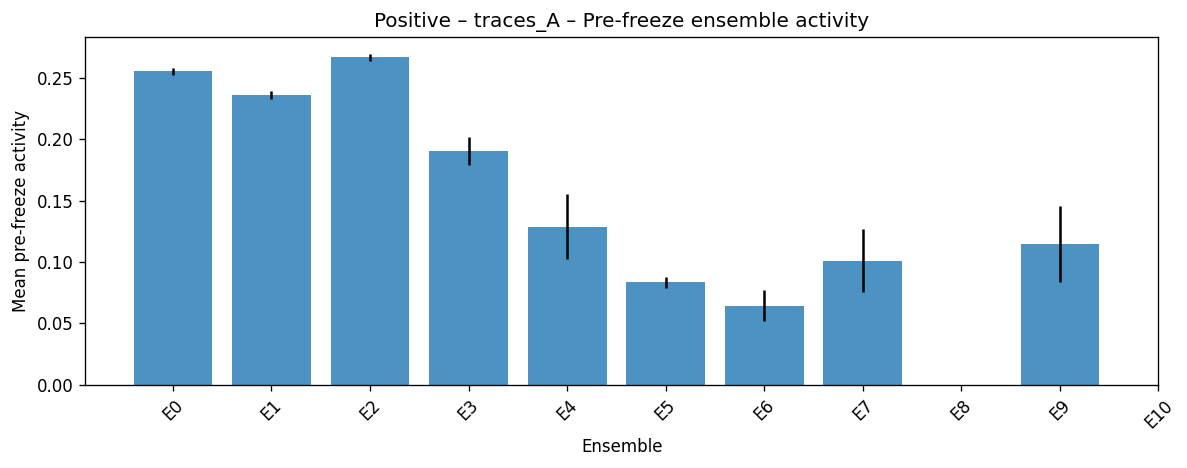

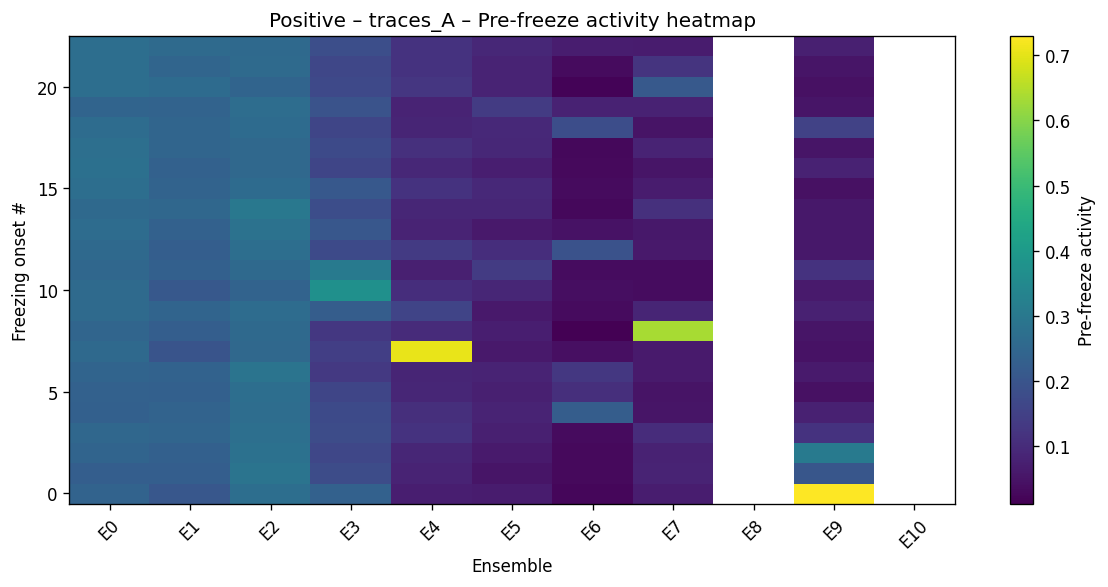

  # freezing onsets used: 23
  # ensembles: 11

 GROUP: POSITIVE | traces_B


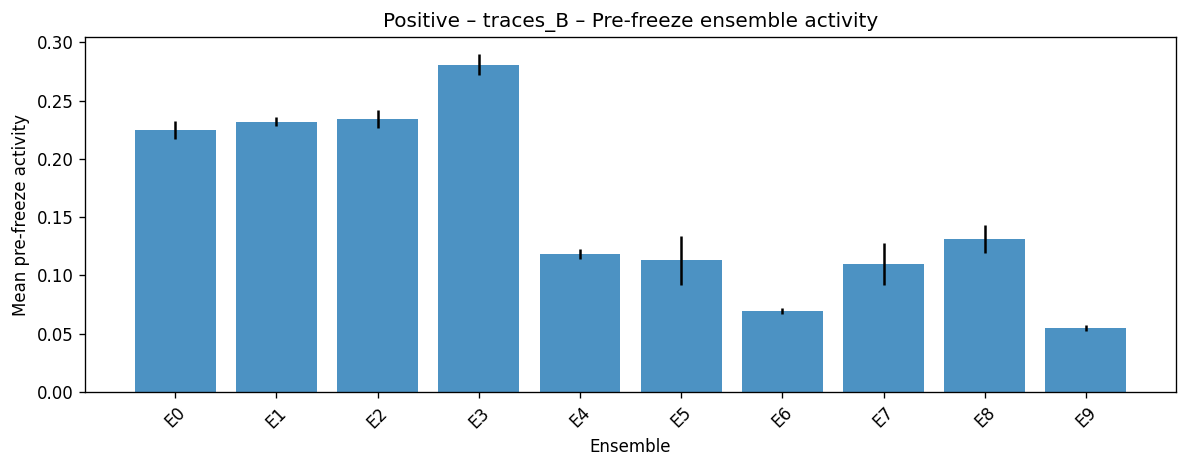

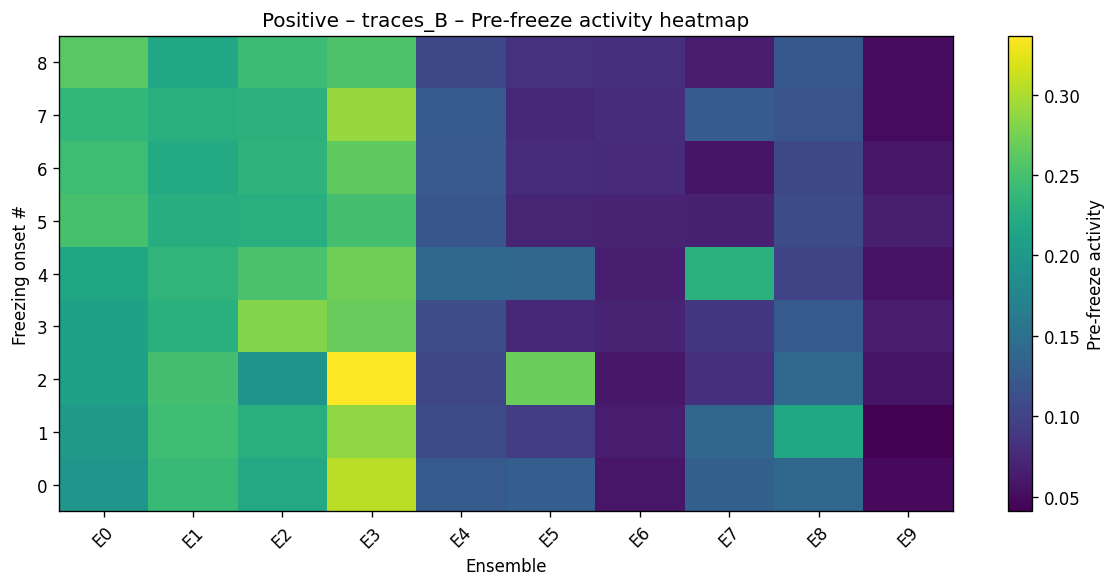

  # freezing onsets used: 9
  # ensembles: 10

 GROUP: NEGATIVE | traces_A


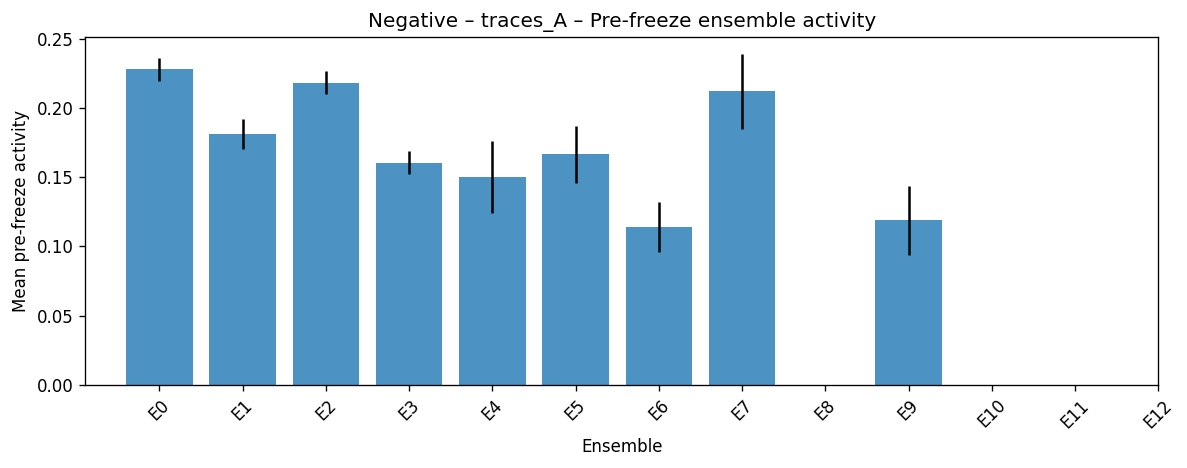

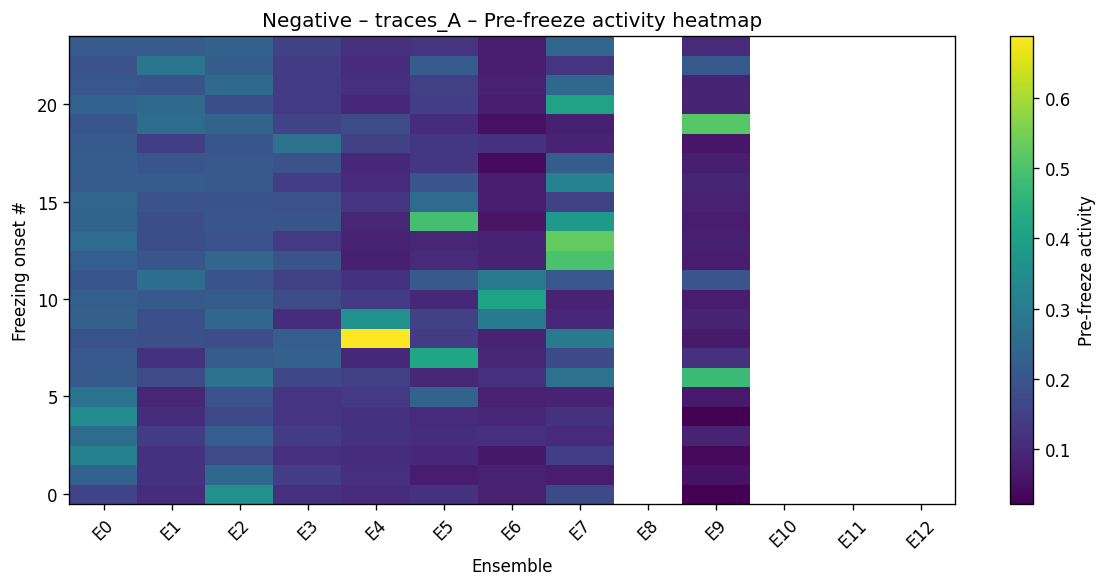

  # freezing onsets used: 24
  # ensembles: 13

 GROUP: NEGATIVE | traces_B


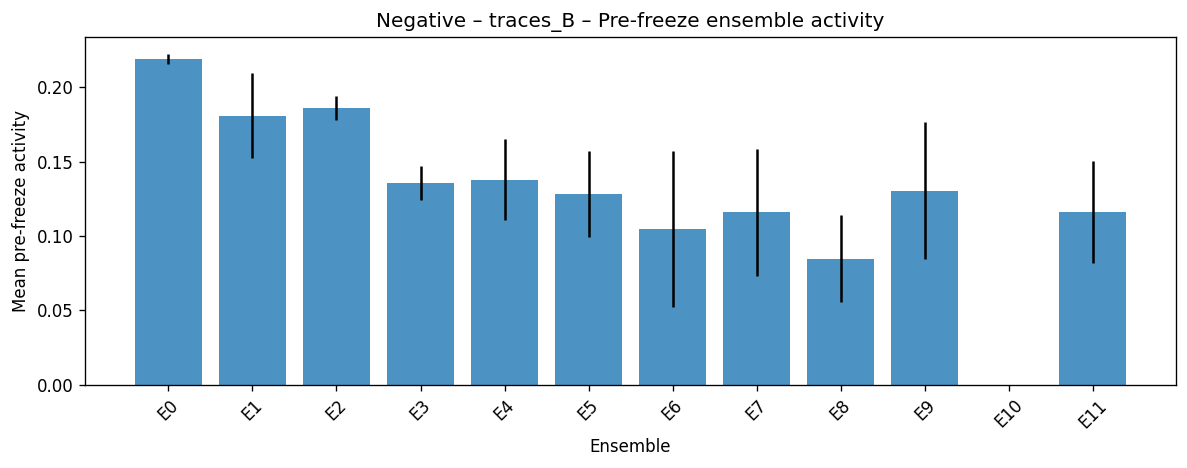

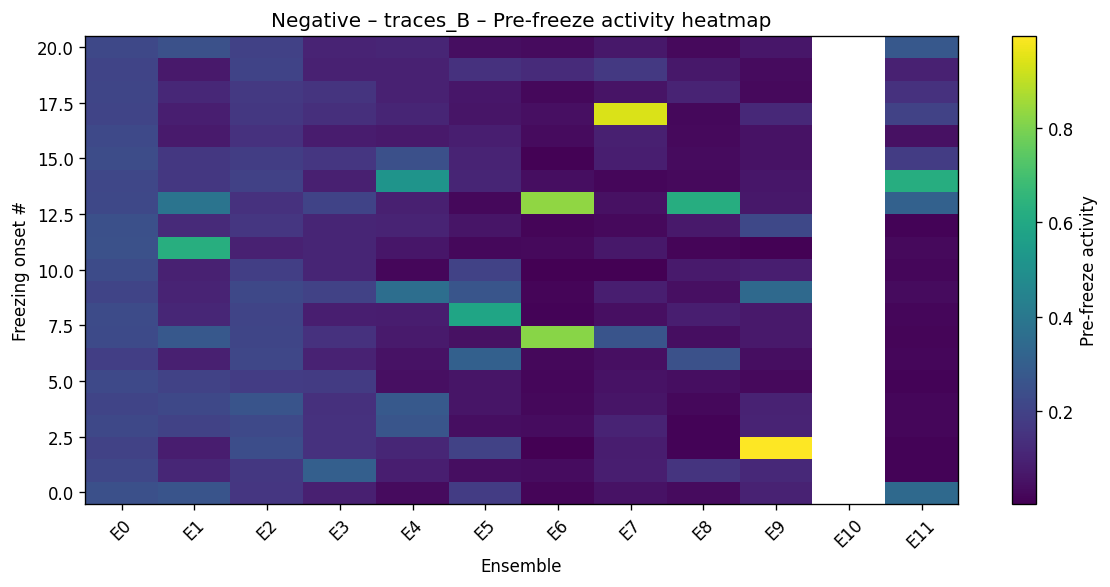

  # freezing onsets used: 21
  # ensembles: 12


In [27]:
# ============================================================
# VISUALIZATION — PRE-FREEZE ENSEMBLE ACTIVITY
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

for group_name in ["positive", "negative"]:
    for trace_key in ["traces_A", "traces_B"]:
        df = pre_freeze_results[group_name].get(trace_key, None)

        print(f"\n======================================")
        print(f" GROUP: {group_name.upper()} | {trace_key}")
        print("======================================")

        if df is None or df.empty:
            print("No pre-freeze data (no onsets or window empty). Skipping.")
            continue

        # ----------------- BAR PLOT: MEAN ± SEM -----------------
        means = df.mean(axis=0, skipna=True)
        sems = df.sem(axis=0, skipna=True)

        ensembles = np.arange(len(means))
        labels = [f"E{i}" for i in ensembles]

        plt.figure(figsize=(10, 4))
        plt.bar(ensembles, means.values, yerr=sems.values, alpha=0.8)
        plt.xticks(ensembles, labels, rotation=45)
        plt.ylabel("Mean pre-freeze activity")
        plt.xlabel("Ensemble")
        plt.title(f"{group_name.capitalize()} – {trace_key} – Pre-freeze ensemble activity")
        plt.tight_layout()
        plt.show()

        # ----------------- HEATMAP: EVENTS × ENSEMBLES -----------------
        data = df.values  # rows = onsets, cols = ensembles

        plt.figure(figsize=(10, 5))
        im = plt.imshow(
            data,
            aspect="auto",
            origin="lower",
            interpolation="nearest"
        )
        plt.colorbar(im, label="Pre-freeze activity")
        plt.xlabel("Ensemble")
        plt.ylabel("Freezing onset #")
        plt.title(f"{group_name.capitalize()} – {trace_key} – Pre-freeze activity heatmap")

        # Put some xticks (if many ensembles, downsample ticks)
        n_ensembles = data.shape[1]
        if n_ensembles <= 20:
            xticks = np.arange(n_ensembles)
        else:
            step = max(1, n_ensembles // 20)
            xticks = np.arange(0, n_ensembles, step)

        plt.xticks(xticks, [f"E{i}" for i in xticks], rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"  # freezing onsets used: {df.shape[0]}")
        print(f"  # ensembles: {df.shape[1]}")
